<div style="text-align:center">
    <h1 style="text-align:center; font-size:50px; margin-bottom: 5px">Fiducial Simulation Analysis</h1>
    <p style="text-align:center;">This notebook demonstrates how to reproduce the plots that examine the fiducial population of Galactic DCOs in Wagg et al. (2021). The two main plots show the distribution of the sources on the LISA sensitivity curve as well as a grid of various parameter distributions. In order to make these plots you'll need the data, which can be found <a href="https://zenodo.org/record/4699713">here</a> on Zenodo.</p>
</div>

In [40]:
# general package imports
import h5py as h5
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import time

# custom LISA package
import legwork

# import code from repo
import sys
sys.path.append("../../simulation/src/")
from variations import variations
from galaxy import simulate_mw
from seaborn_utility import cmap_from_colour
from bootstrap import bootstrapped_kde, bootstrapped_ecdf, bootstrapped_Z
from verification_binaries import verification_binaries

In [2]:
# config stuff to make plots look pretty
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
fs = 20

params = {'legend.fontsize': fs,
         'axes.labelsize': fs,
         'xtick.labelsize':0.7*fs,
         'ytick.labelsize':0.7*fs}
plt.rcParams.update(params)

In [5]:
# define what DCOs we are working with and a colour scheme
dco_types = ["BHBH", "BHNS", "NSNS"]
dco_colours = {"BHBH": plt.get_cmap("plasma")(0.2), 
               "BHNS": plt.get_cmap("plasma")(0.5),
               "NSNS": plt.get_cmap("plasma")(0.8)}

# IMPORTANT: these need to point to the folders where you stored the data from Zenodo
data_folder = "../../simulation/data/"
sim_folder = data_folder + "simulation_high_res_double/"

# load a bunch of data
total_DCOs_in_MW = np.load(data_folder + "total_DCO_in_MW.npy")
total_bound_DCOs_in_MW = np.load(data_folder + "total_DCO_in_MW_nohubble.npy")
detections_4yr = np.load(data_folder + "detections_4yr.npy")
detections_10yr = np.load(data_folder + "detections_10yr.npy")

In [6]:
detections_4yr[:, 0].mean(axis=1).round(0)

array([36., 33.,  8.])

In [7]:
detections_10yr[:, 0].mean(axis=1).round(0)

array([56., 55., 13.])

# Uncertainties
To start, we can first consider what the uncertainties on the eccentricity, chirp mass and sky position are (since we'll need them for the grid plot). Let's start with eccentricity.

## Eccentricity uncertainty

In [8]:
def get_ecc_uncertainty(t_obs=4*u.yr, source_threshold=7, harmonic_threshold=7, model="fiducial"):
    detectable_harmonics = {"BHBH": None, "BHNS": None, "NSNS": None}
    snr_uncertainty = {"BHBH": None, "BHNS": None, "NSNS": None}
    ecc_uncertainty = {"BHBH": None, "BHNS": None, "NSNS": None}
    max_harmonics = {"BHBH": None, "BHNS": None, "NSNS": None}

    for i, dco_type in enumerate(dco_types):
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, model), "r") as f:
            full_data = f["simulation"][...].squeeze()
            snr_mask = full_data["snr"] * np.sqrt(t_obs / (4 * u.yr)) > source_threshold
            data = full_data[snr_mask]

        sources = legwork.source.Source(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                        dist=data["dist"] * u.kpc, a=data["a_LISA"] * u.AU,
                                        ecc=data["e_LISA"])

        detectable_harmonics[dco_type] = np.zeros(len(data)).astype(int)
        snr_uncertainty[dco_type] = np.zeros(len(data))
        max_harmonics[dco_type] = np.zeros(len(data)).astype(int)

        harmonics_required = sources.harmonics_required(sources.ecc)

        harmonic_groups = [(1, 10), (10, 100), (100, 1000), (1000, 10000)]
        for lower, upper in harmonic_groups:
            match = np.logical_and(harmonics_required > lower, harmonics_required <= upper)
            if match.any():
                snr_n_2 = legwork.snr.snr_ecc_stationary(m_c=sources.m_c[match],
                                                         f_orb=sources.f_orb[match],
                                                         ecc=sources.ecc[match],
                                                         dist=sources.dist[match],
                                                         t_obs=t_obs,
                                                         harmonics_required=upper,
                                                         interpolated_g=sources.g,
                                                         interpolated_sc=sources.sc,
                                                         ret_snr2_by_harmonic=True)

                # count harmonics above threshold
                detectable_harmonics[dco_type][match] = (snr_n_2**0.5 > harmonic_threshold).astype(int).sum(axis=1)
                
                max_harmonics[dco_type][match] = np.argmax(snr_n_2, axis=1) + 1

                # get the top two harmonics and sum them to get uncertainty
                top_snrs = np.sort(snr_n_2**(0.5), axis=1)[:, -2:]
                snr_uncertainty[dco_type][match] = 1 / top_snrs[:, 0] + 1 / top_snrs[:, -1]

        # set uncertainty differently if detectable harmonics are < 2
        ecc_uncertainty[dco_type] = snr_uncertainty[dco_type]
#         ecc_uncertainty[dco_type][detectable_harmonics[dco_type] == 0] = 0.9
#         ecc_uncertainty[dco_type][detectable_harmonics[dco_type] == 1] = 0.1
        
    return detectable_harmonics, snr_uncertainty, ecc_uncertainty, max_harmonics

In [9]:
detectable_harmonics, snr_uncertainty, ecc_uncertainty, max_harmonics = get_ecc_uncertainty(harmonic_threshold=3, model=variations[0]["file"], t_obs=4*u.yr)

### Plot detectable harmonics

In [6]:
def plot_detectable_harmonics(min_ecc=0.0, max_ecc=1.0, groups=[(0, 1), (1, 2), (2, 3), (3, np.inf)], 
                              labels=["0", "1", "2", ">2"], dco_types=dco_types, model="fiducial",
                              detection_threshold=7, xlabel="Individually detectable harmonics",
                              t_obs=4*u.yr):
    
    fig, axes = plt.subplots(1, 3, figsize=(5 * len(dco_types), 5))
    fig.subplots_adjust(wspace=0.0)

    for i, dco_type in enumerate(dco_types):
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, model), "r") as f:
            full_data = f["simulation"][...].squeeze()
            snr_mask = full_data["snr"] * np.sqrt(t_obs / (4 * u.yr)) > detection_threshold
            data = full_data[snr_mask]

        colors = [dco_colours[dco_type][0:3] + (0.2 * j,) for j in range(1, len(labels) + 1)]
        sizes = np.zeros(len(groups))
        for g in range(len(groups)):
            lh, hh = groups[g]
            mask = np.logical_and.reduce((detectable_harmonics[dco_type] >= lh,
                                          detectable_harmonics[dco_type] < hh,
                                          data["e_LISA"] >= min_ecc,
                                          data["e_LISA"] <= max_ecc))
            sizes[g] = np.sum(data["weight"][mask])
            
        print(np.sum(data["weight"][detectable_harmonics[dco_type] != 1]) / np.sum(data["weight"]))

        axes[i].pie(sizes, labels=labels, radius=1, wedgeprops=dict(width=0.5, edgecolor='w'), colors=colors)
        axes[i].annotate(dco_types[i], xy=(0.5, 0.5), xycoords="axes fraction", ha="center", va="center", fontsize=fs)

    axes[1].set_xlabel(xlabel)

    plt.show()

0.5467896561170543
0.2677188093194404
0.6528915959035868


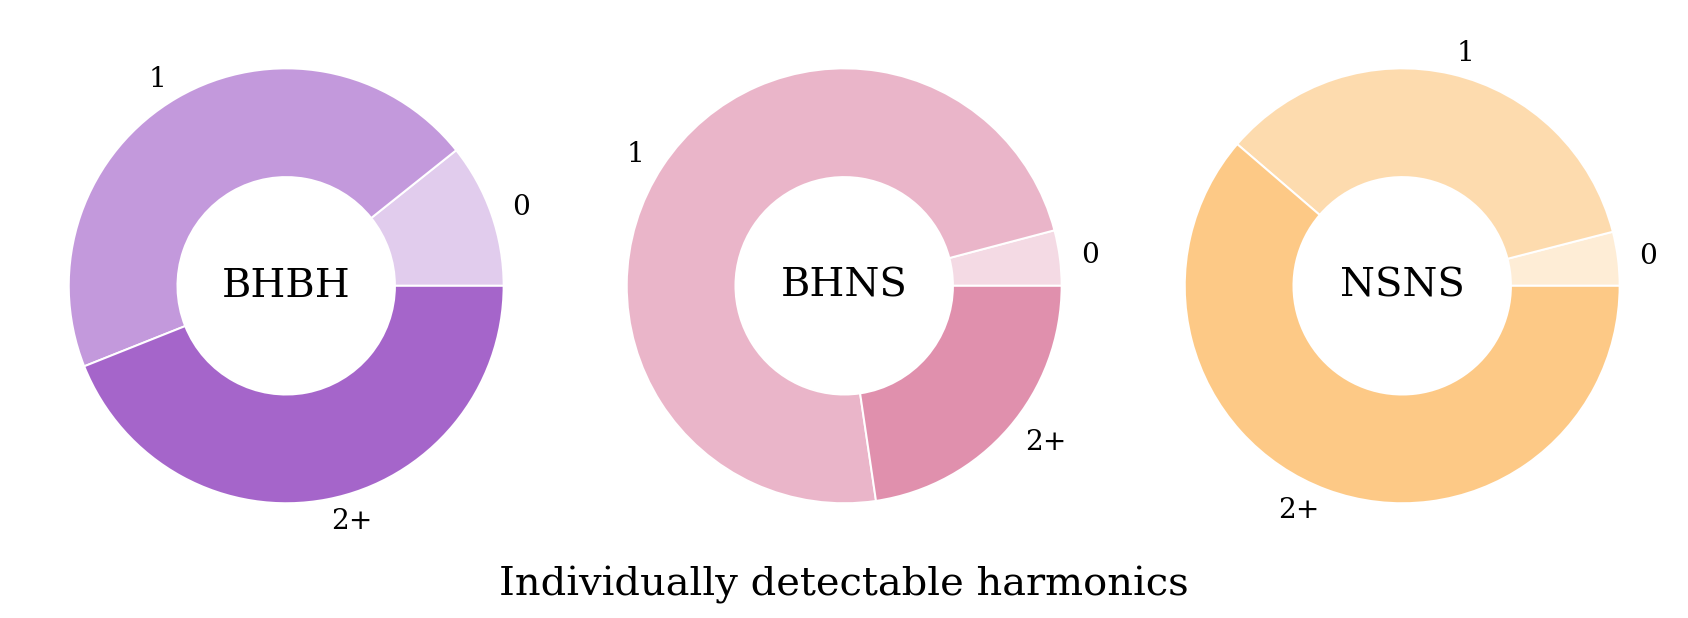

In [34]:
plot_detectable_harmonics(min_ecc=0.00, groups=[(0,1), (1, 2), (2, np.inf)], labels=["0", "1", "2+"], t_obs=4*u.yr)

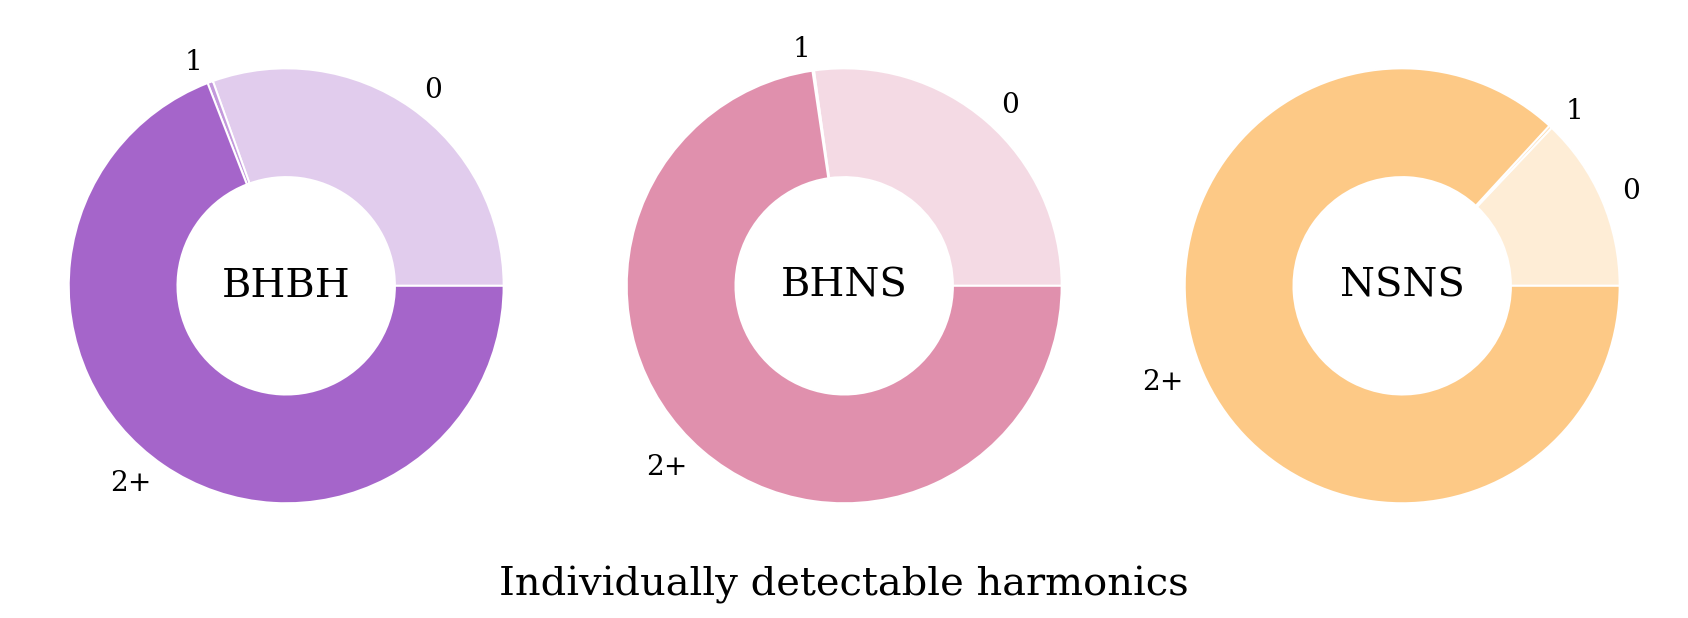

In [55]:
plot_detectable_harmonics(min_ecc=0.1, groups=[(0,1), (1, 2), (2, np.inf)], labels=["0", "1", "2+"])

## Other uncertainties

In [10]:
def sky_localisation(snr, fGW, L=2*u.AU):
    sigma_theta = 16.6 * (7 / snr) * (5e-4 * u.Hz / fGW) * (2 * u.AU / L) * u.deg
    return sigma_theta.to(u.deg)

def get_f_orb_uncertainty(snr, t_obs, f_orb):
    return (4 * np.sqrt(3) / np.pi / (snr * t_obs) / f_orb).decompose()

def get_f_orb_dot_uncertainty(snr, t_obs, f_orb_dot):
    return (6 * np.sqrt(5) / np.pi / (snr * t_obs**2) / f_orb_dot).decompose()

def get_Fprime_over_F(e):
    return e * (1256 + 1608 * e**2 + 111 * e**4) / (96 + 196 * e**2 - 255 * e**4 - 37 * e**6)

def get_m_c_uncertainty(f_orb, f_orb_dot, ecc, ecc_uncertainty, snr, t_obs):
    f_orb_uncertainty = get_f_orb_uncertainty(snr, t_obs, f_orb)
    f_orb_dot_uncertainty = get_f_orb_dot_uncertainty(snr, t_obs, f_orb_dot)
    
    return 11 / 5 * f_orb_uncertainty \
            + 3 / 5 * f_orb_dot_uncertainty \
            + 3 / 5 * get_Fprime_over_F(ecc) * ecc_uncertainty

def get_m_c_uncertainty_alt(f_orb, f_orb_dot, ecc, ecc_uncertainty, snr, t_obs):
    f_orb_uncertainty = get_f_orb_uncertainty(snr, t_obs, f_orb)
    f_orb_dot_uncertainty = get_f_orb_dot_uncertainty(snr, t_obs, f_orb_dot)
    
    return np.sqrt((11 / 5 * f_orb_uncertainty)**2 + (3 / 5 * f_orb_dot_uncertainty)**2 + (3 / 5 * get_Fprime_over_F(ecc) * ecc_uncertainty)**2)

# Print some stats for results section

## Masses and Eccentricity

In [18]:
t_obs = 4 * u.yr
detection_threshold = 7

In [86]:
for i, dco_type in enumerate(dco_types):
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, "fiducial"), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * np.sqrt(t_obs / (4 * u.yr)) > detection_threshold
        data = full_data[snr_mask]

    if dco_type == "BHNS":
        mBH = np.maximum(data["m_1"], data["m_2"])
        mNS = np.minimum(data["m_1"], data["m_2"])
        mass_weights = data["weight"]
        mass_seeds = data["seed"]
    elif dco_type == "BHBH":
        mBH = np.concatenate((data["m_1"], data["m_2"]))
        mNS = None
        mass_weights = np.concatenate((data["weight"], data["weight"]))
        mass_seeds = np.concatenate((data["seed"], -1 * data["seed"]))
    elif dco_type == "NSNS":
        mNS = np.concatenate((data["m_1"], data["m_2"]))
        mBH = None
        mass_weights = np.concatenate((data["weight"], data["weight"]))
        mass_seeds = np.concatenate((data["seed"], -1 * data["seed"]))
    
    print(dco_type)
    print("======")
    if mBH is not None:
        print("mBH < 11", (np.sum(mass_weights[mBH < 11]) / np.sum(mass_weights)).round(2))
        print("mBH mass gap", (np.sum(mass_weights[np.logical_and(mBH > 2, mBH < 5)]) / np.sum(mass_weights)).round(2))
    if mNS is not None:
        print("mNS < 1.7", (np.sum(mass_weights[mNS < 1.7]) / np.sum(mass_weights)).round(2))
    
    print("e < 0.01", (np.sum(data["weight"][data["e_LISA"] < 0.01]) / np.sum(data["weight"])).round(2))
    print("e > 0.01", (np.sum(data["weight"][data["e_LISA"] > 0.01]) / np.sum(data["weight"])).round(2))
    print("e > 0.3", (np.sum(data["weight"][data["e_LISA"] > 0.3]) / np.sum(data["weight"])).round(2))
    print()

BHBH
mBH < 11 0.88
mBH mass gap 0.35
e < 0.01 0.14
e > 0.01 0.86
e > 0.3 0.2

BHNS
mBH < 11 0.91
mBH mass gap 0.39
mNS < 1.7 0.77
e < 0.01 0.54
e > 0.01 0.46
e > 0.3 0.08

NSNS
mNS < 1.7 0.91
e < 0.01 0.14
e > 0.01 0.86
e > 0.3 0.12



64.71246177106387
224.7484923177178
31.526151457261363
33.743270062335455
25.934741197475063



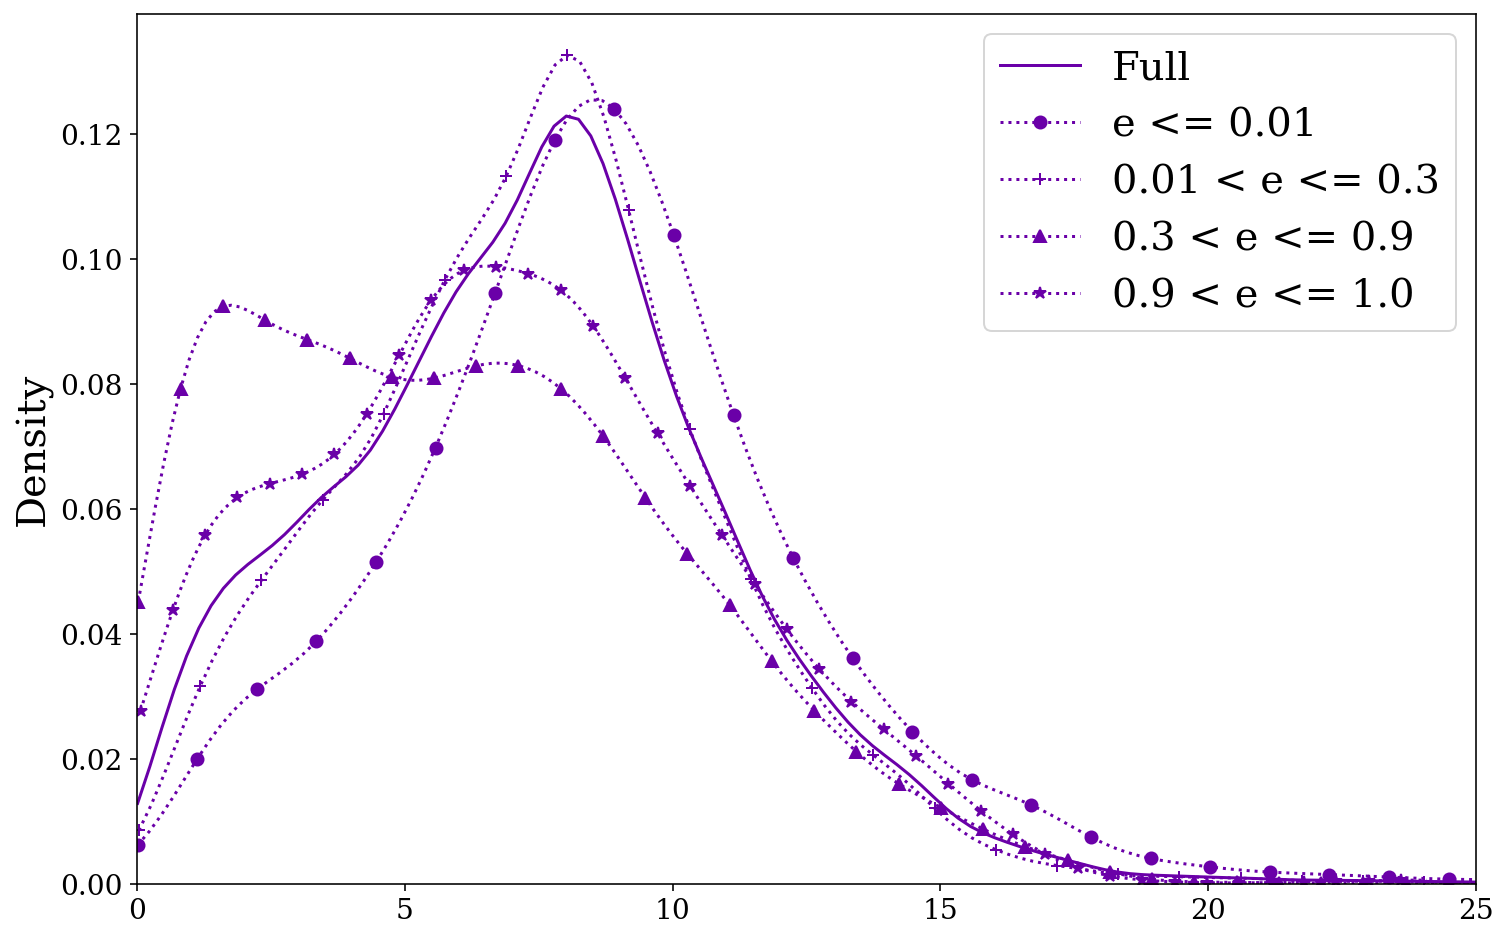

54.1116096235916
68.50227792915396
24.434001009953025
24.55322978392814
15.709495339827713



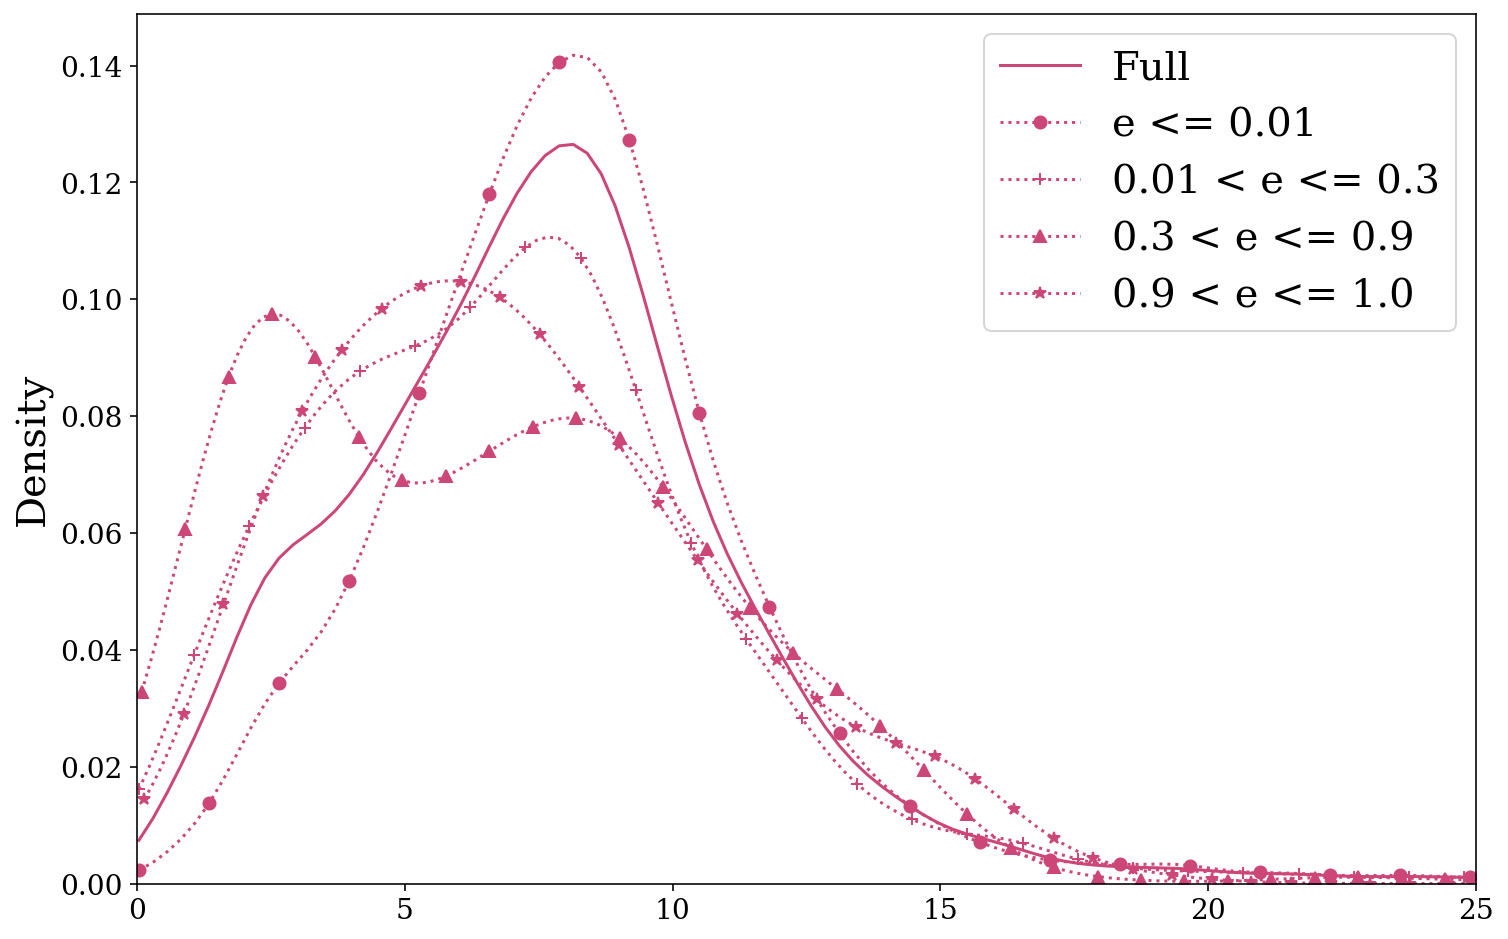

46.152855698644146
146.44804291547172
38.620358448796274
18.44884519176054
17.028174060633905



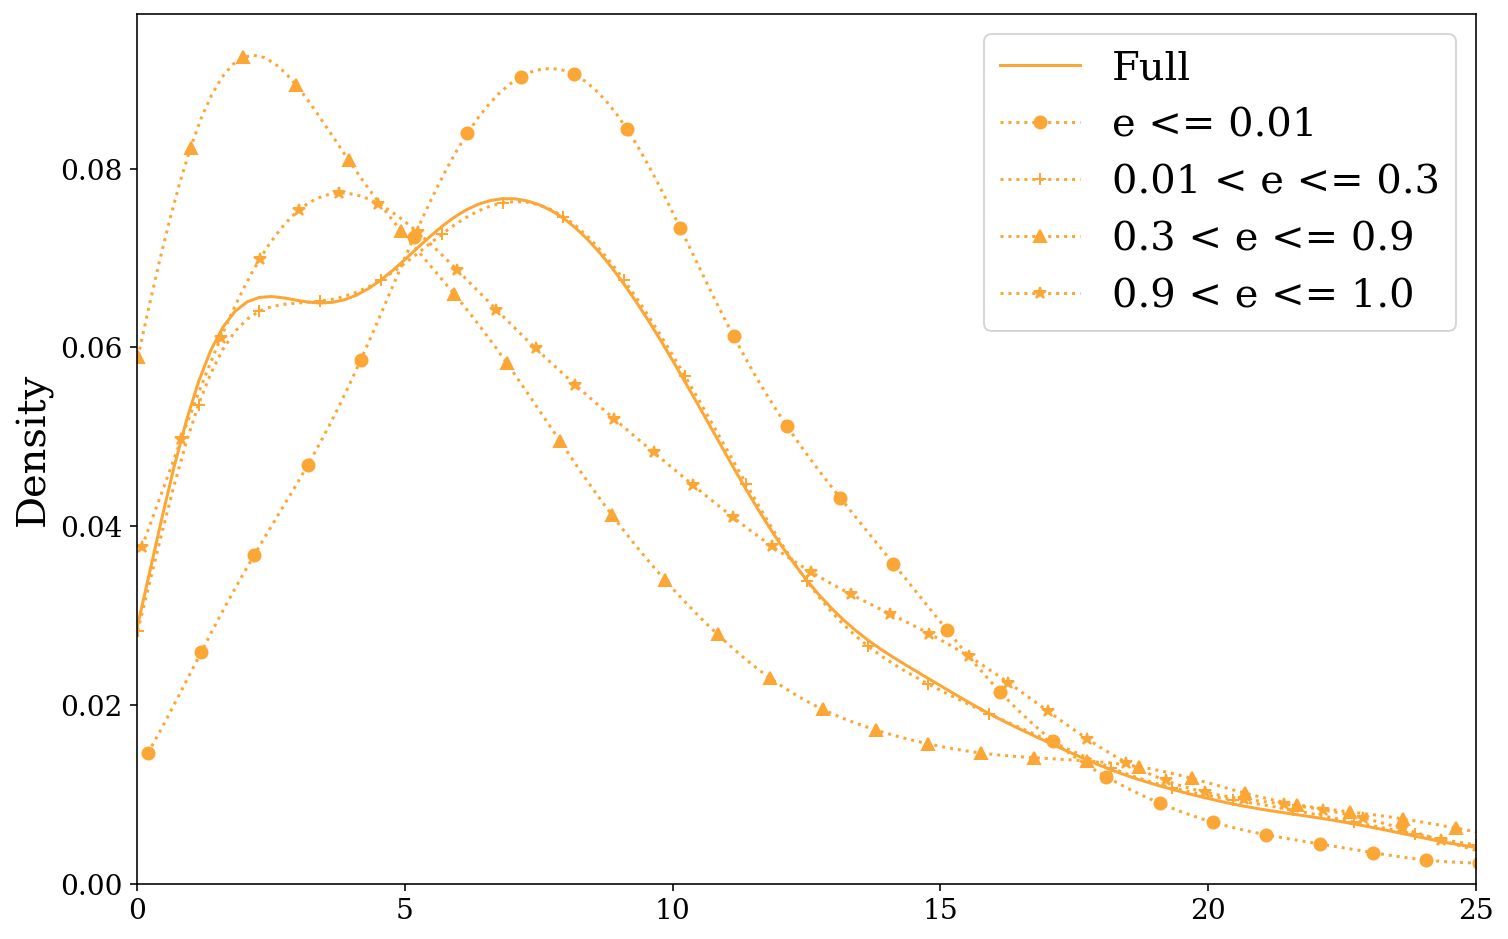

In [89]:
for i, dco_type in enumerate(dco_types):
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, "fiducial"), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * np.sqrt(t_obs / (4 * u.yr)) > detection_threshold
        data = full_data[snr_mask]
        
    f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                  a=data["a_LISA"] * u.AU).to(u.mHz)
        
    sns.kdeplot(data["dist"], weights=data["weight"], color=dco_colours[dco_type], cut=0, label="Full")
    print(np.mean(data["snr"]))
    
    for lower, upper, label, marker in [(1e-10, 0.01, "e <= 0.01", 'o'), (0.01, 0.3, "0.01 < e <= 0.3", '+'),
                                (0.3, 0.9, "0.3 < e <= 0.9", "^"), (0.9, 1.0, "0.9 < e <= 1.0", "*")]: 
        mask = np.logical_and(data["e_LISA"] > lower, data["e_LISA"] <= upper)
        sns.kdeplot(data["dist"][mask], weights=data["weight"][mask], color=dco_colours[dco_type], linestyle="dotted", cut=0, label=label, marker=marker, markevery=5)
        print(np.mean(data["snr"][mask]))

    print()
        
    plt.legend()

    plt.xlim(0, 25)

    plt.show()

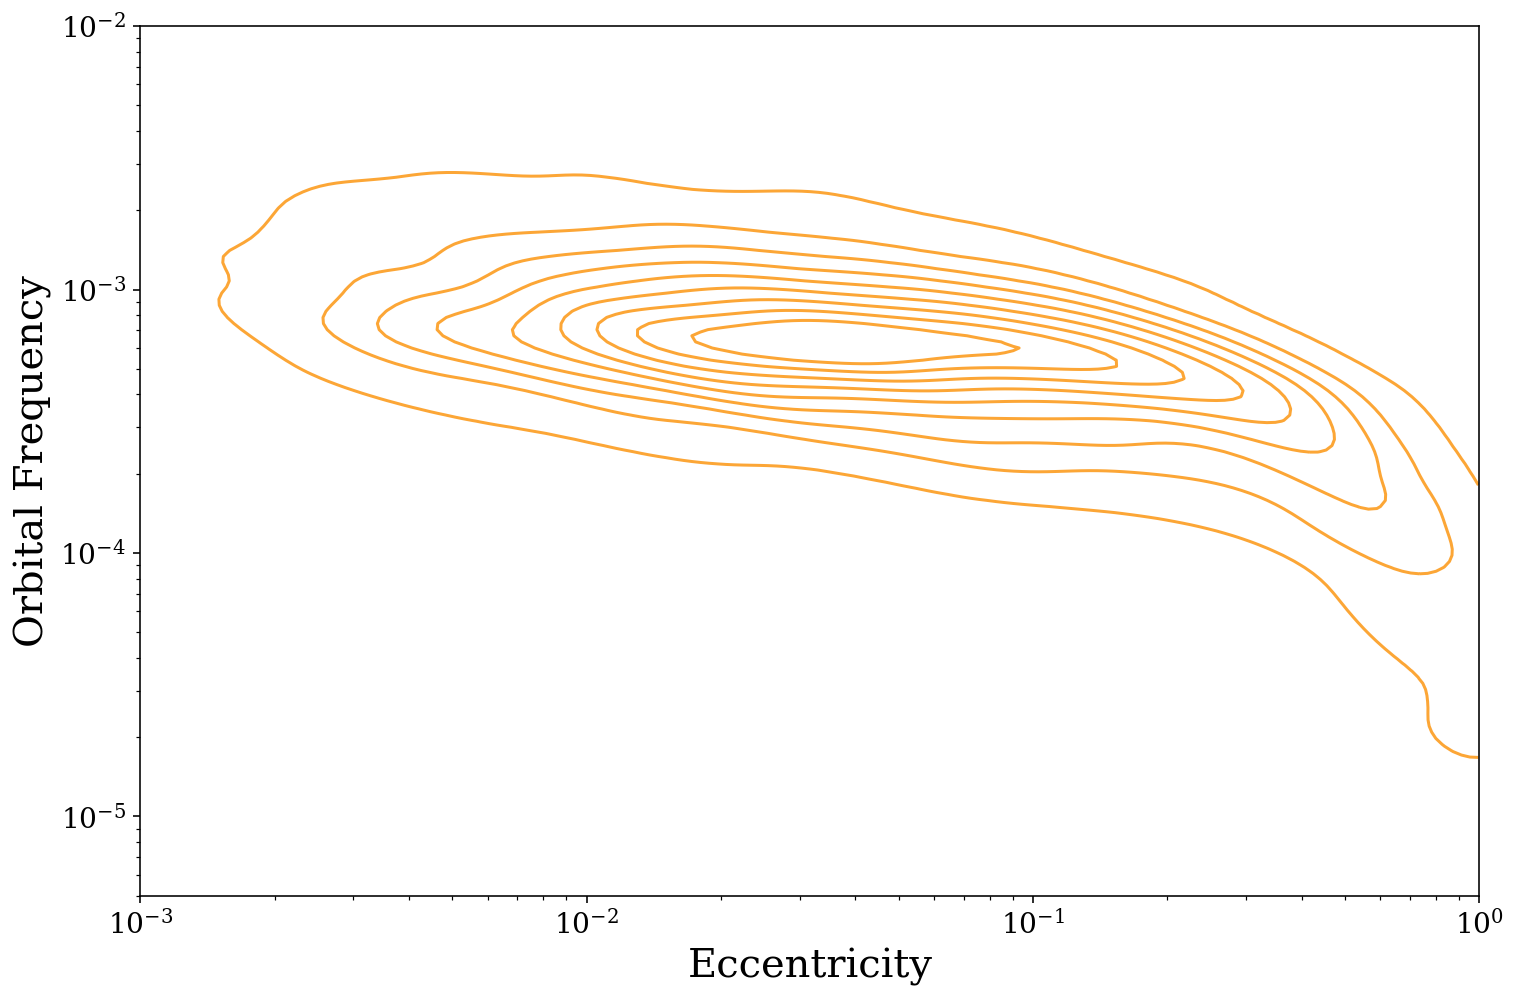

In [94]:
for i, dco_type in enumerate(["NSNS"]):
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, "fiducial"), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * np.sqrt(t_obs / (4 * u.yr)) > detection_threshold
        data = full_data[snr_mask]
        
    f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                  a=data["a_LISA"] * u.AU)
    
#     plt.scatter(data["e_LISA"], f_orb_LISA, s=data["weight"], color=dco_colours[dco_type])
    sns.kdeplot(x=data["e_LISA"], y=f_orb_LISA, weights=data["weight"], color=dco_colours[dco_type], log_scale=(True, True), cut=0)
    
    plt.xscale("log")
    plt.yscale("log")
    
    plt.ylim(5e-6, 1e-2)
    plt.xlim(1e-3, 1e0)
    
    plt.xlabel("Eccentricity")
    plt.ylabel("Orbital Frequency")

    plt.show()

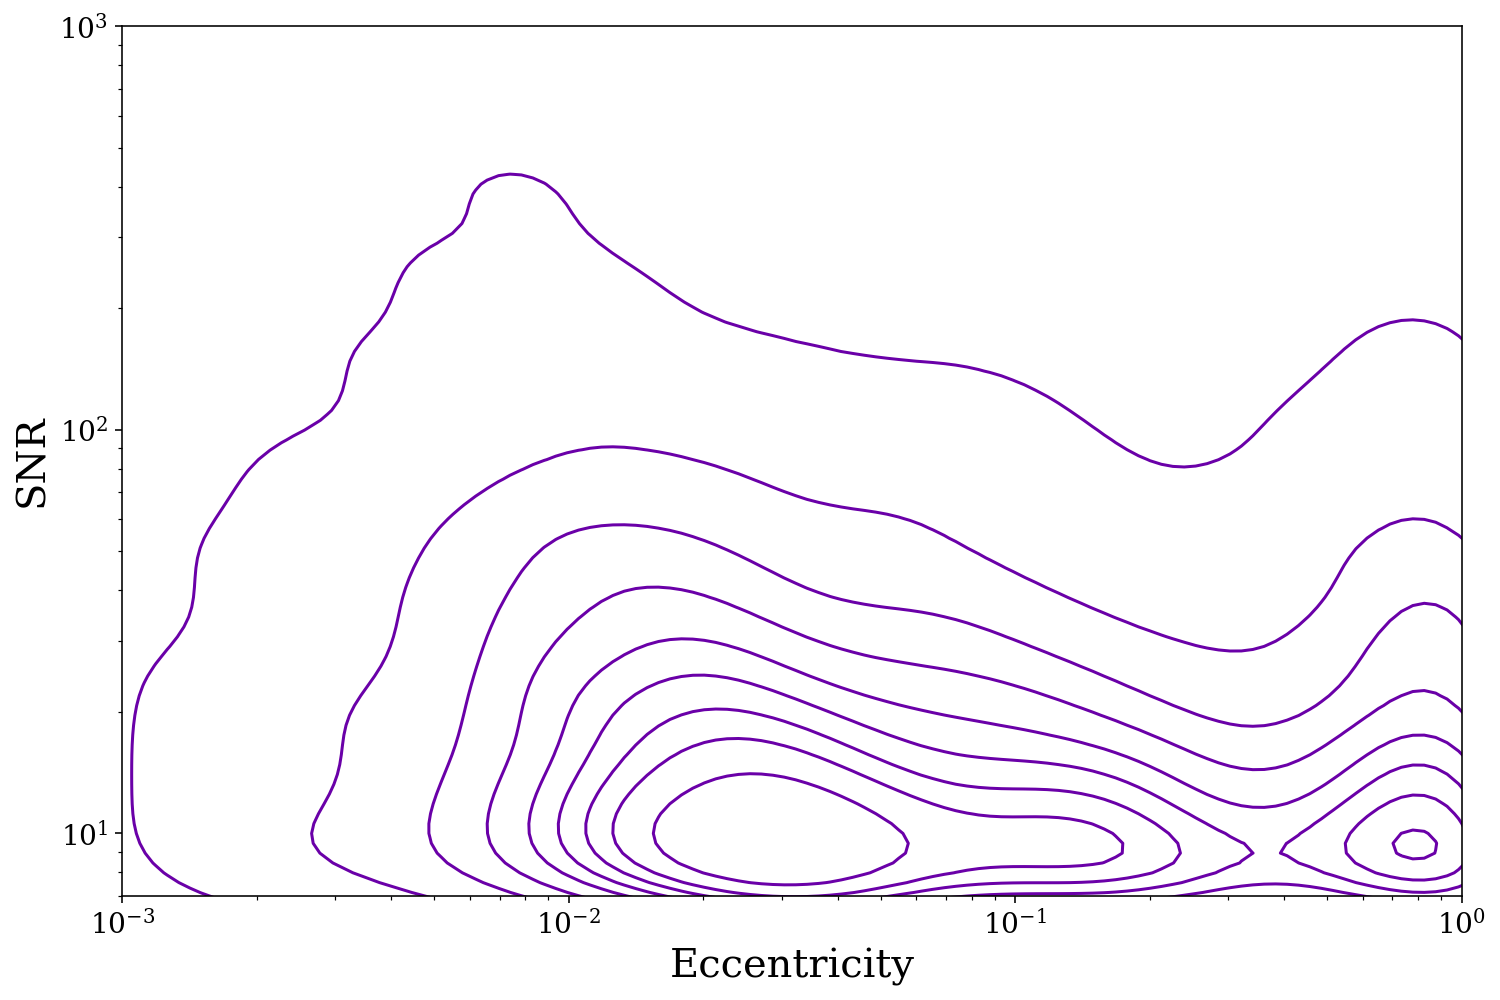

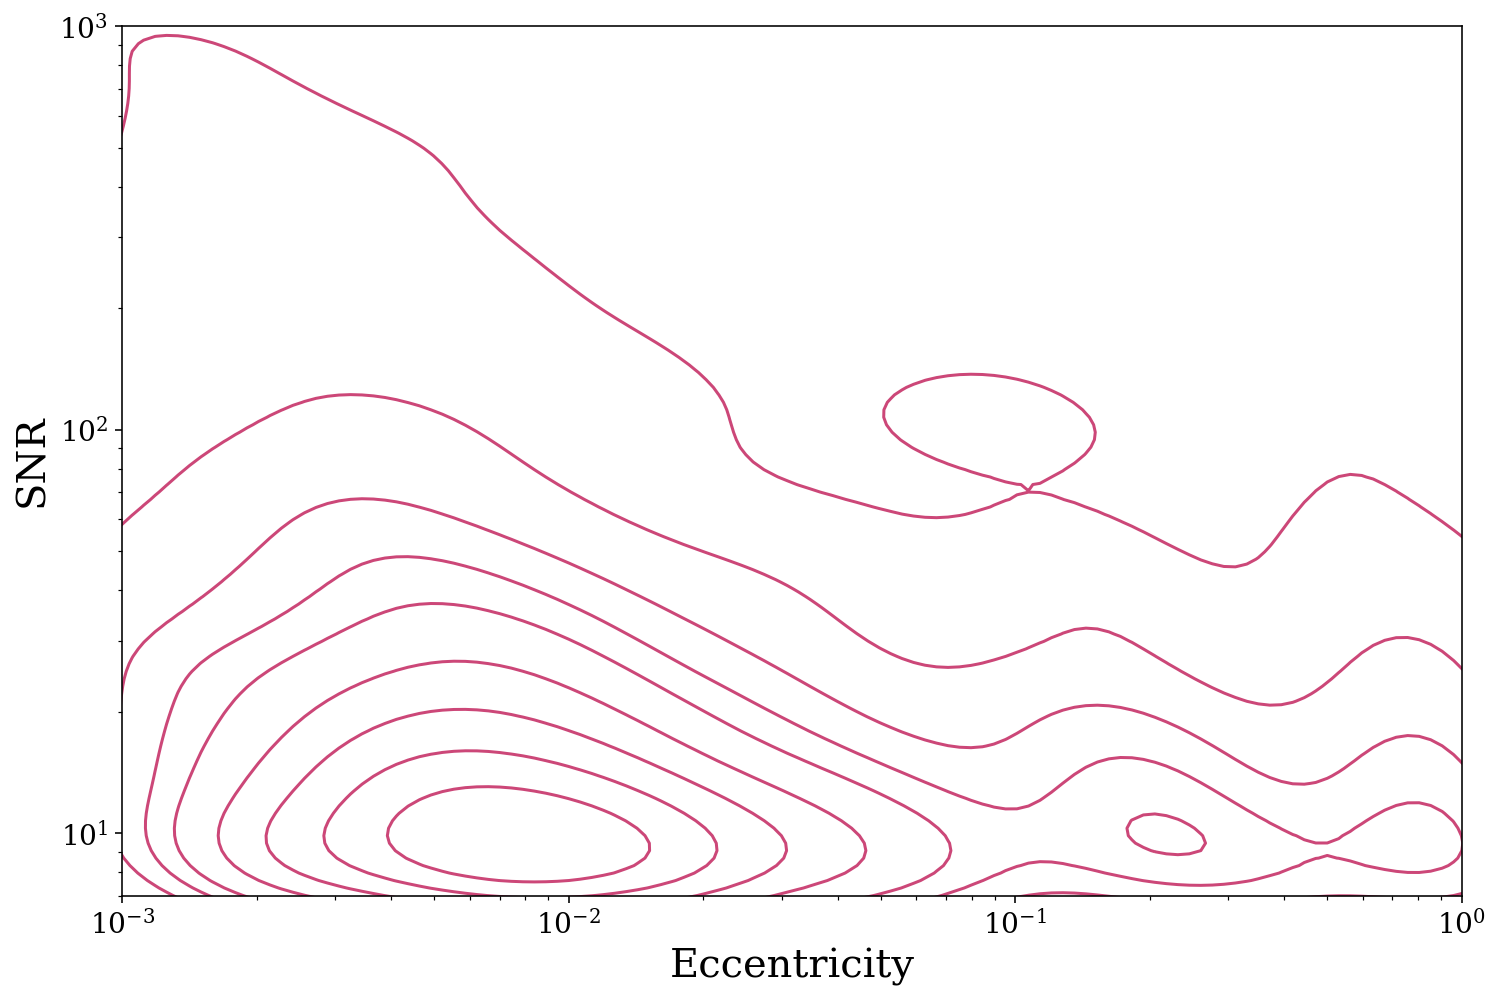

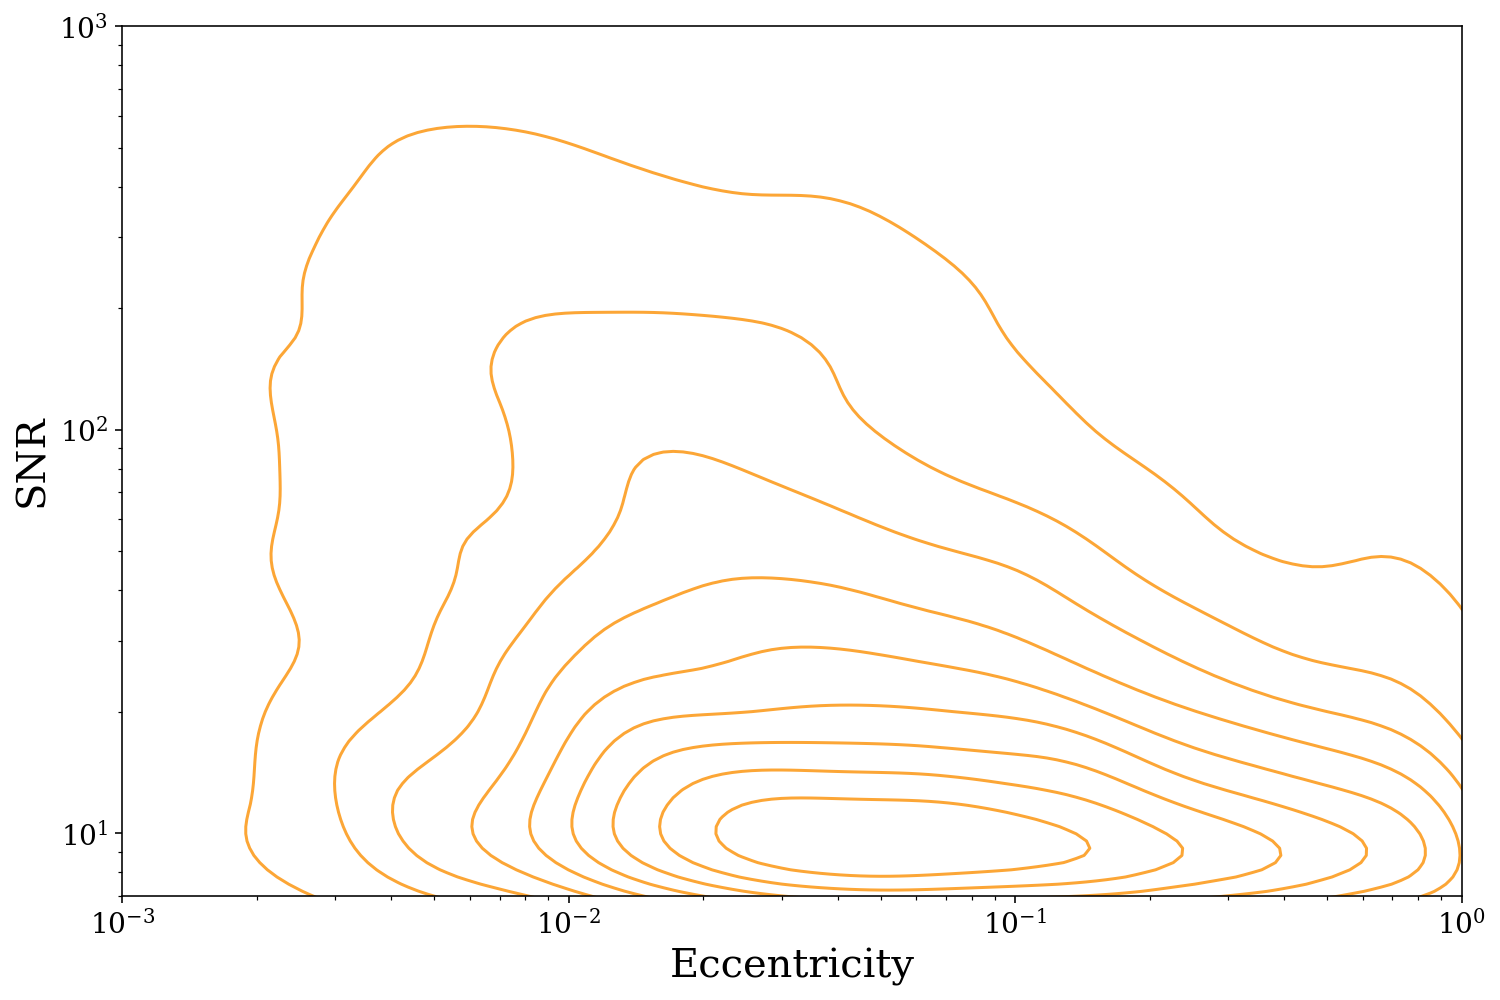

In [95]:
for i, dco_type in enumerate(dco_types):
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, "fiducial"), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * np.sqrt(t_obs / (4 * u.yr)) > detection_threshold
        data = full_data[snr_mask]
        
    f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                  a=data["a_LISA"] * u.AU)
    
#     plt.scatter(data["e_LISA"], data["snr"], s=data["weight"] * 10, color=dco_colours[dco_type])
    sns.kdeplot(x=data["e_LISA"], y=data["snr"], weights=data["weight"], log_scale=(True, True), color=dco_colours[dco_type])
    
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(7, 1e3)
    plt.xlim(1e-3, 1e0)
    
    plt.xlabel("Eccentricity")
    plt.ylabel("SNR")

    plt.show()

## Distinguishing detections

In [65]:
mc_wd = legwork.utils.chirp_mass(1.44, 1.44) * u.Msun
mc_ns = legwork.utils.chirp_mass(2.5, 2.5) * u.Msun
print(mc_wd.round(2), mc_ns.round(2))

1.25 solMass 2.18 solMass


In [66]:
print("t_obs = {:1.0f}".format(t_obs.value))
print()

for i, dco_type in enumerate(dco_types):
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, "fiducial"), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * np.sqrt(t_obs / (4 * u.yr)) > detection_threshold
        data = full_data[snr_mask]

    f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                  a=data["a_LISA"] * u.AU)
    
    m_c = legwork.utils.chirp_mass(data["m_1"] * u.Msun, data["m_2"] * u.Msun)
    
    sigma_theta = sky_localisation(data["snr"], f_orb_LISA * max_harmonics[dco_type]).to(u.deg)
    f_orb_dot = legwork.utils.fn_dot(m_c=m_c, f_orb=f_orb_LISA, e=data["e_LISA"], n=1)
    f_orb_dot_u = get_f_orb_dot_uncertainty(data["snr"], t_obs, f_orb_dot)
    
    f_orb_u = get_f_orb_uncertainty(data["snr"], t_obs, f_orb_LISA)
    
    D_Mc = get_m_c_uncertainty(f_orb_LISA * max_harmonics[dco_type], f_orb_dot * max_harmonics[dco_type], data["e_LISA"], ecc_uncertainty[dco_type], data["snr"], t_obs).decompose()
    
    WDWD_limit = m_c > mc_wd + (2 * D_Mc * m_c)
    NSNS_difference = np.abs(m_c - mc_ns)
    NSNS_limit = NSNS_difference > 2 * D_Mc * m_c
    
    resolved_in_disc = np.repeat(True, len(data))
    z_scale_thick = 0.95 * u.kpc
    far_enough = data["dist"] > z_scale_thick.value
    another_angle = np.arcsin(z_scale_thick / (data["dist"][far_enough] * u.kpc)).to(u.deg)

    resolved_in_disc[far_enough] = sigma_theta[far_enough] < another_angle
    
    eccentric = detectable_harmonics[dco_type] != 1
    ecc_and_in_disc = np.logical_and(eccentric, resolved_in_disc)
    not_WDWD = np.logical_or(WDWD_limit, ecc_and_in_disc)
    
    limits = [("m_c > WDWD", WDWD_limit), ("eccentric", eccentric), ("in disc", resolved_in_disc),
              ("ecc + disc", ecc_and_in_disc), ("not WDWD", not_WDWD),
              ("BH or NS", NSNS_limit)]

    print(dco_type)
    print("========")
    for label, mask in limits:
        fraction = np.sum(data["weight"][mask]) / np.sum(data["weight"])
        if t_obs == 10 * u.yr:
            print("{}:\t\t fraction={:1.2f}, detections={:1.0f}".format(label, fraction, fraction * np.median(detections_10yr[i][0])))
        else:
            print("{}:\t\t fraction={:1.2f}, detections={:1.0f}".format(label, fraction, fraction * np.median(detections_4yr[i][0])))
            
    print()

t_obs = 4

BHBH
m_c > WDWD:		 fraction=0.17, detections=6
eccentric:		 fraction=0.55, detections=19
in disc:		 fraction=0.54, detections=19
ecc + disc:		 fraction=0.40, detections=14
not WDWD:		 fraction=0.45, detections=16
BH or NS:		 fraction=0.15, detections=5

BHNS
m_c > WDWD:		 fraction=0.20, detections=6
eccentric:		 fraction=0.27, detections=8
in disc:		 fraction=0.68, detections=20
ecc + disc:		 fraction=0.24, detections=7
not WDWD:		 fraction=0.36, detections=11
BH or NS:		 fraction=0.12, detections=4

NSNS
m_c > WDWD:		 fraction=0.03, detections=0
eccentric:		 fraction=0.65, detections=5
in disc:		 fraction=0.87, detections=7
ecc + disc:		 fraction=0.59, detections=5
not WDWD:		 fraction=0.59, detections=5
BH or NS:		 fraction=0.34, detections=3



# Parameter distributions

## Properties of detectable sources

In [41]:
def detectable_properties_grid(model=0, t_obs=4 * u.yr, bootstraps=200, dco_types=dco_types,
                               colours=dco_colours, save_fig=True, file_name=None,
                               fig=None, axes=None, show=True,
                               lower_mass_gap=False, eccentricity_labels=False, legend=True):
    
    start = time.time()

    detection_total = detections_4yr if t_obs == 4 * u.yr else detections_10yr
    
    if fig is None or axes is None:
        fig, axes = plt.subplots(2, 3, figsize=(22, 10))
    plt.subplots_adjust(top=0.96, hspace=0.25)
    lw = 4
    
    # loop over each DCO type
    for i, dco_type in enumerate(dco_types):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            full_data = f["simulation"][...].squeeze()
            snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

            data = full_data[snr_mask]
            
            if bootstraps is None:
                # make everything unique and adjust weights
                _, uni_index, uni_count = np.unique(data["seed"],
                                                    return_index=True, return_counts=True)
                data = data[uni_index]
                data["weight"] = data["weight"] * uni_count
        
        # convert separation to frequency
        f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                    a=data["a_LISA"] * u.AU)
        print(variations[model]["med"], dco_type, len(data["m_1"]))

        # work out which masses are the BH and NS masses
        if dco_type == "BHNS":
            mBH = np.maximum(data["m_1"], data["m_2"])
            mNS = np.minimum(data["m_1"], data["m_2"])
            mass_weights = data["weight"]
            mass_seeds = data["seed"]
        elif dco_type == "BHBH":
            mBH = np.concatenate((data["m_1"], data["m_2"]))
            mass_weights = np.concatenate((data["weight"], data["weight"]))
            mass_seeds = np.concatenate((data["seed"], -1 * data["seed"]))
        elif dco_type == "NSNS":
            mNS = np.concatenate((data["m_1"], data["m_2"]))
            mass_weights = np.concatenate((data["weight"], data["weight"]))
            mass_seeds = np.concatenate((data["seed"], -1 * data["seed"]))
        
        # plot the orbital frequency distribution
        print("\t Plotting orbital frequency")
        if bootstraps is not None:
            axes[0, 0] = bootstrapped_kde(np.log10(f_orb_LISA.value), data["weight"], data["seed"],
                                          ax=axes[0, 0], color=colours[dco_type], label=dco_type,
                                          bootstraps=bootstraps)
        else:
            sns.kdeplot(np.log10(f_orb_LISA.value), weights=data["weight"], ax=axes[0, 0],
                        color=colours[dco_type], label=dco_type)
        axes[0, 0].set_xlabel(r"Orbital Frequency, $\log_{10} (f_{\rm orb, LISA} / {\rm Hz})$")
        axes[0, 0].set_xlim(-5.1, -2.1)
        
        # plot the BH mass distribution
        print("\t Plotting black hole mass")
        if dco_type in ["BHNS", "BHBH"]:
            if bootstraps is not None:
                axes[0, 1] = bootstrapped_kde(mBH, mass_weights, mass_seeds, bw_adjust=1.4,
                                              ax=axes[0, 1], color=colours[dco_type], label=dco_type,
                                              bootstraps=bootstraps)
            else:
                sns.kdeplot(mBH, weights=mass_weights, ax=axes[0, 1], bw_adjust=1.4,
                        color=colours[dco_type], label=dco_type, cut=0)
            
            if model == 8:
                min_mass = np.min(mBH)
                axes[0, 1].plot([min_mass, min_mass], [0, 0.065], color=colours[dco_type])
            
            axes[0, 1].set_xlabel(r"Black Hole Mass, $m_{\rm BH} \, [\rm M_{\odot}]$")
            axes[0, 1].set_xlim(2.6, 21)
            axes[0, 1].set_ylim(0, 0.36)
            
            if dco_type == "BHBH":
                ax_right = axes[0, 1].twinx()
                sns.kdeplot(data["m_1"], weights=data["weight"], bw_adjust=1.4, ax=ax_right,
                            color=colours[dco_type], label=dco_type, linestyle="dotted")
                sns.kdeplot(data["m_2"], weights=data["weight"], bw_adjust=1.4, ax=ax_right,
                            color=colours[dco_type], label=dco_type, linestyle="dotted")
                
                ax_right.set_ylim(0, axes[0, 1].get_ylim()[-1] * 4)
                ax_right.set_yticks([])
                ax_right.set_ylabel("")

        # plot the NS mass distribution
        print("\t Plotting neutron star mass")
        if dco_type in ["BHNS", "NSNS"]:
            if bootstraps is not None:
                axes[0, 2] = bootstrapped_kde(mNS, mass_weights, data["seed"], bw_adjust=0.5, log_scale=(False, True),
                                              ax=axes[0, 2], color=colours[dco_type], label=dco_type,
                                              bootstraps=bootstraps)
            else:
                sns.kdeplot(mNS, weights=mass_weights, ax=axes[0, 2], bw_adjust=0.5, log_scale=(False, True),
                            color=colours[dco_type], label=dco_type, cut=0)
            axes[0, 2].set_xlabel(r"Neutron Star Mass, $m_{\rm NS} \, [\rm M_{\odot}]$")
            axes[0, 2].set_xlim(1.26, 2.5)
            
        # plot the eccentricity distribution
        print("\t Plotting eccentricity")
        if bootstraps is not None:
            axes[1, 0] = bootstrapped_kde(np.log10(data["e_LISA"]), data["weight"], data["seed"],
                                          ax=axes[1, 0], color=colours[dco_type], label=dco_type, bw_adjust=1.5,
                                          bootstraps=bootstraps)    
        else:
            sns.kdeplot(np.log10(data["e_LISA"]), weights=data["weight"], ax=axes[1, 0],
                        color=colours[dco_type], label=dco_type, bw_adjust=1.5)
            
        axes[1, 0].set_xlabel(r"Eccentricity, $\log_{10} (e_{\rm LISA})$")
        axes[1, 0].set_xlim(-4, 0)

        # plot the distance distribution
        print("\t Plotting distance")
        if bootstraps is not None:
            axes[1, 1] = bootstrapped_kde(data["dist"], data["weight"], data["seed"],
                                          ax=axes[1, 1], color=colours[dco_type], label=dco_type,
                                          bootstraps=bootstraps)
        else:
            sns.kdeplot(data["dist"], weights=data["weight"], ax=axes[1, 1],
                        color=colours[dco_type], label=dco_type)
            
        axes[1, 1].set_xlabel(r"Luminosity Distance, $D_{\rm L} \, [\rm kpc]$")
        axes[1, 1].set_xlim(0, 25)
        axes[1, 1].axvline(8.2, color="grey", linestyle="dotted", zorder=0)
        axes[1, 1].annotate("Milky Way Centre", xy=(8.2, 0.01), color="grey", rotation=90, ha="center",
                            bbox=dict(boxstyle="round", ec="white", fc="white"), fontsize=0.6*fs)
        
        # plot the lookback time
        print("\t Plotting lookback time")
        if bootstraps is not None:
            axes[1, 2] = bootstrapped_kde(data["tau"], data["weight"], data["seed"],
                                          ax=axes[1, 2], color=colours[dco_type], label=dco_type,
                                          bootstraps=bootstraps)
        else:
            sns.kdeplot(data["tau"], weights=data["weight"], ax=axes[1, 2],
                        color=colours[dco_type], label=dco_type)
            
        axes[1, 2].set_xlabel(r"Lookback Time, $\tau \, [\rm Gyr]$")
        axes[1, 2].set_xlim(0, 12)
        
    if lower_mass_gap:
        axes[0, 1].axvspan(2.5, 5.0, color="grey", alpha=0.25)
        axes[0, 1].annotate("Lower mass gap", xy=(3.75, 0.3), color="grey", rotation=90, ha="center", fontsize=0.6*fs, va="top")
        
    if eccentricity_labels:
        for e in [0.01, 0.3]:
            axes[1, 0].axvline(np.log10(e), color="grey", linestyle="dotted")
            axes[1, 0].annotate(r"$e = {{{}}}$".format(e), xy=(np.log10(e), 0.04 if e < 0.1 else 0.4), color="grey",
                                bbox=dict(boxstyle="round", ec="white", fc="white"), ha="center", rotation=90, fontsize=0.7*fs)
    
    if legend:
        handles, labels = axes[0, 0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', fontsize=fs, ncol=3, borderaxespad=0.0)

    for ax in axes.flatten():
        ax.tick_params(labelsize=0.7*fs)
        ax.set_ylabel("PDF")#ax.set_ylabel("")
        ax.xaxis.label.set_fontsize(fs)
        
        if ax.get_yscale() == "linear":
            ax.set_ylim(bottom=0.0)
        
    axes[0, 0].set_ylabel("PDF")
    axes[1, 0].set_ylabel("PDF")

    if save_fig:
        if file_name is not None:
            plt.savefig("../../paper/figures/" + file_name, format="pdf", bbox_inches="tight")
        elif t_obs == 4 * u.yr:
            plt.savefig("../../paper/figures/detectable_properties_4yr.pdf", format="pdf", bbox_inches="tight")
        else:
            plt.savefig("../../paper/figures/detectable_properties_10yr.pdf", format="pdf", bbox_inches="tight")

    if show:
        plt.show()
        
    print()
    print("Plot complete, it took {:1.1f} seconds".format(time.time() - start))
    
    return fig, axes

fiducial BHBH 46424
	 Plotting orbital frequency
	 Plotting black hole mass
	 Plotting neutron star mass
	 Plotting eccentricity
	 Plotting distance
	 Plotting lookback time
fiducial BHNS 44927
	 Plotting orbital frequency
	 Plotting black hole mass
	 Plotting neutron star mass
	 Plotting eccentricity
	 Plotting distance
	 Plotting lookback time
fiducial NSNS 32805
	 Plotting orbital frequency
	 Plotting black hole mass
	 Plotting neutron star mass
	 Plotting eccentricity
	 Plotting distance
	 Plotting lookback time


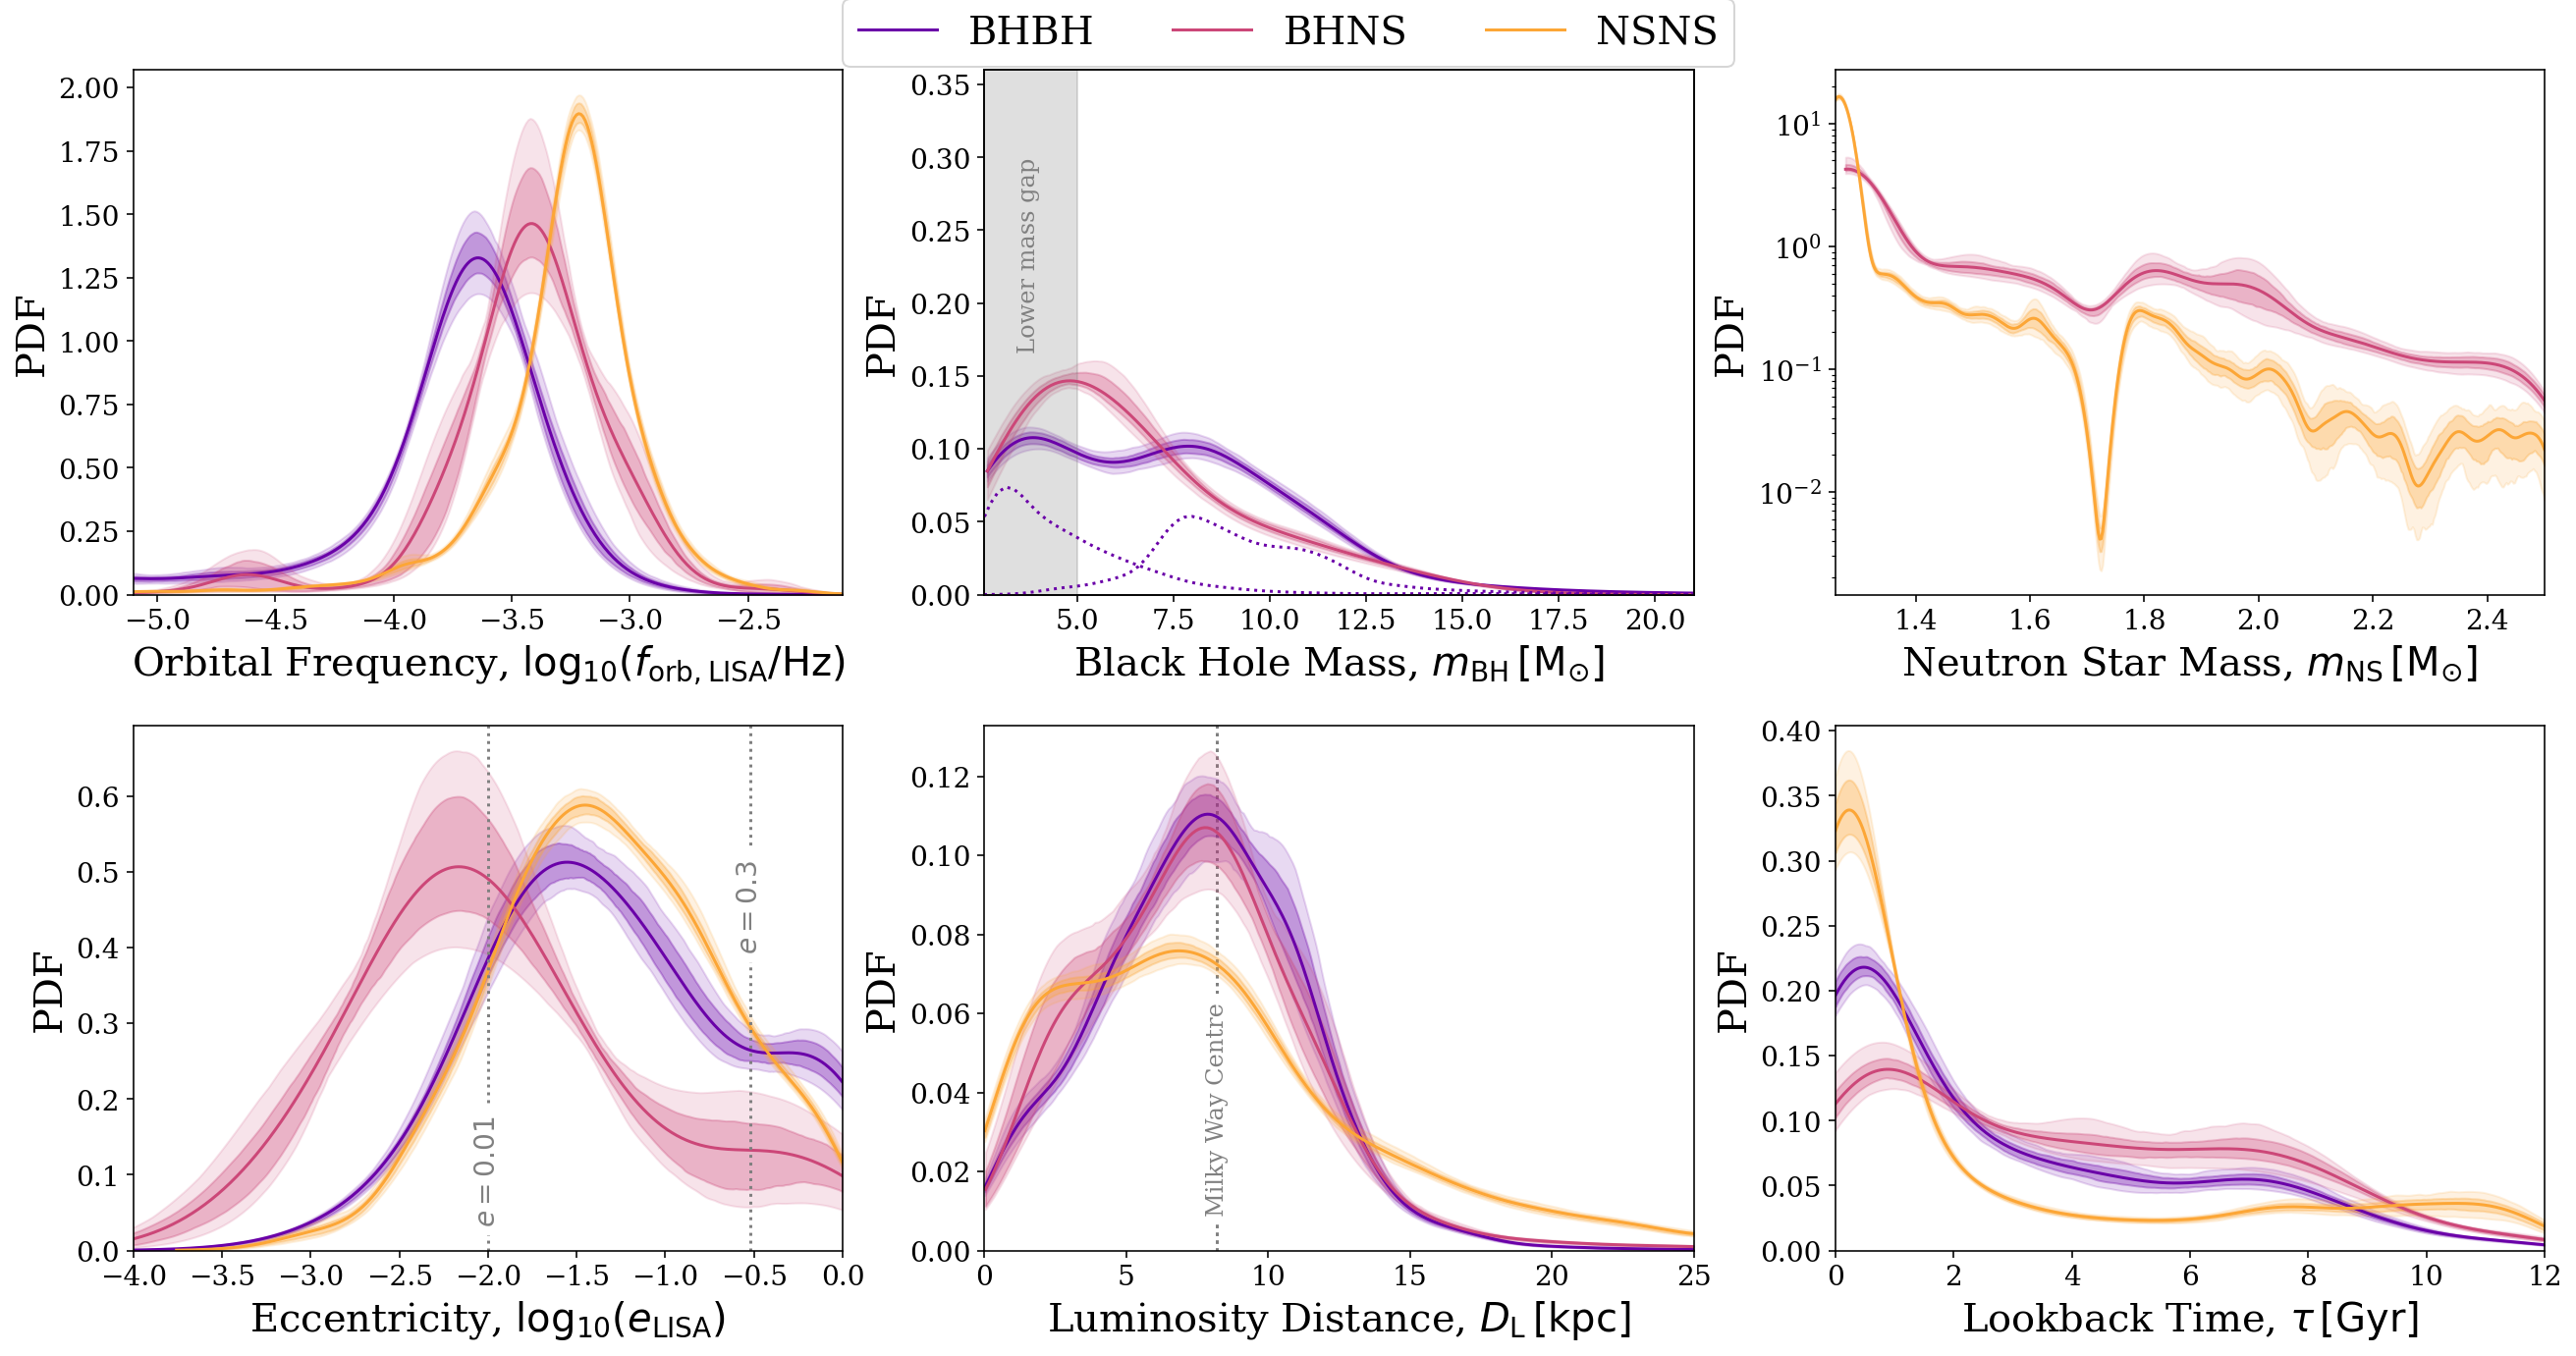

(<Figure size 1584x720 with 7 Axes>,
 array([[<AxesSubplot:xlabel='Orbital Frequency, $\\log_{10} (f_{\\rm orb, LISA} / {\\rm Hz})$', ylabel='PDF'>,
         <AxesSubplot:xlabel='Black Hole Mass, $m_{\\rm BH} \\, [\\rm M_{\\odot}]$', ylabel='PDF'>,
         <AxesSubplot:xlabel='Neutron Star Mass, $m_{\\rm NS} \\, [\\rm M_{\\odot}]$', ylabel='PDF'>],
        [<AxesSubplot:xlabel='Eccentricity, $\\log_{10} (e_{\\rm LISA})$', ylabel='PDF'>,
         <AxesSubplot:xlabel='Luminosity Distance, $D_{\\rm L} \\, [\\rm kpc]$', ylabel='PDF'>,
         <AxesSubplot:xlabel='Lookback Time, $\\tau \\, [\\rm Gyr]$', ylabel='PDF'>]],
       dtype=object))

In [39]:
detectable_properties_grid(lower_mass_gap=True, eccentricity_labels=True, file_name="4_detectable_properties_4yr.pdf")

## Measurement uncertainties

In [ ]:
def measurement_uncertaines(model=0, t_obs=4 * u.yr, bootstraps=200, dco_types=dco_types,
                               colours=dco_colours, save_fig=False, file_name=None):
    detection_total = detections_4yr if t_obs == 4 * u.yr else detections_10yr
    
    fig, axes = plt.subplots(figsize=(7, 5))
    plt.subplots_adjust(top=0.96, hspace=0.25)
    lw = 4
    
    # loop over each DCO type
    for i, dco_type in enumerate(dco_types):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            full_data = f["simulation"][...].squeeze()
            snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

            data = full_data[snr_mask]
            
        detection_total = detections_4yr if t_obs == 4 * u.yr else detections_10yr
        
        f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                    a=data["a_LISA"] * u.AU)

        m_c = legwork.utils.chirp_mass(data["m_1"], data["m_2"]) * u.Msun
        f_orb_dot = legwork.utils.fn_dot(m_c=m_c, f_orb=f_orb_LISA, e=data["e_LISA"], n=1)
        sigma_theta = sky_localisation(data["snr"], f_orb_LISA * max_harmonics[dco_type]).to(u.deg)
    
        D_Mc = get_m_c_uncertainty(f_orb_LISA * max_harmonics[dco_type], f_orb_dot * max_harmonics[dco_type],
                                   data["e_LISA"], ecc_uncertainty[dco_type], data["snr"], t_obs).decompose()
        
        print(variations[model]["med"], dco_type, len(data["m_1"]))

        
    
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', fontsize=fs, ncol=3, borderaxespad=0.0)

    for ax in axes.flatten():
        ax.tick_params(labelsize=0.7*fs)
        ax.set_ylabel("")
        ax.xaxis.label.set_fontsize(fs)
        
        if ax.get_yscale() == "linear":
            ax.set_ylim(bottom=0.0)
        
    axes[0, 0].set_ylabel("PDF")
    axes[1, 0].set_ylabel("PDF")

    if save_fig:
        if file_name is not None:
            plt.savefig(file_name, format="pdf", bbox_inches="tight")
        elif t_obs == 4 * u.yr:
            plt.savefig("../../paper/figures/detectable_properties_4yr.pdf", format="pdf", bbox_inches="tight")
        else:
            plt.savefig("../../paper/figures/detectable_properties_10yr.pdf", format="pdf", bbox_inches="tight")

    plt.show()

In [67]:
def kdeplot_something(variable, dco_type_list=["BHBH", "BHNS", "NSNS"], variation_index=0,
                      fig=None, ax=None, show=True, count_limit=np.inf, channel=None, **kwargs):
    if fig is None or ax is None:   
        fig, ax = plt.subplots(1, figsize=(10, 5))

    for dco_type in dco_type_list:
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[variation_index]["file"]), "r") as f:
            full_data = f["simulation"][...].squeeze()
            snr_mask = full_data["snr"] > 7

            data = full_data[snr_mask]
            
            unique_seeds, counts = np.unique(data["seed"], return_counts=True)
            count_mask = np.isin(data["seed"], unique_seeds[counts < count_limit])
            
            data = data[count_mask]
            if channel is not None:
                data = data[np.isin(data["channel"], channel)]

        sns.kdeplot(data[variable], weights=data["weight"], color=dco_colours[dco_type], cut=0, lw=4, **kwargs)

    if show:
        plt.show()
    return fig, ax

In [2]:
from astropy.coordinates import SkyCoord

In [7]:
b = np.repeat(10, 2000) * u.deg
l = np.linspace(0, 360, 2000) * u.deg

[-10. -10. -10. ... -10. -10. -10.] deg
[52.09811512 52.13284136 52.16679308 ... 51.98931076 52.02634762
 52.06261648]
[0. 0. 0. ... 0. 0. 0.] deg
[62.29043617 62.32518982 62.35890315 ... 62.17997315 62.21782377
 62.25464615]
[10. 10. 10. ... 10. 10. 10.] deg
[72.48270702 72.51751653 72.55074219 ... 72.36887172 72.40837464
 72.44632312]


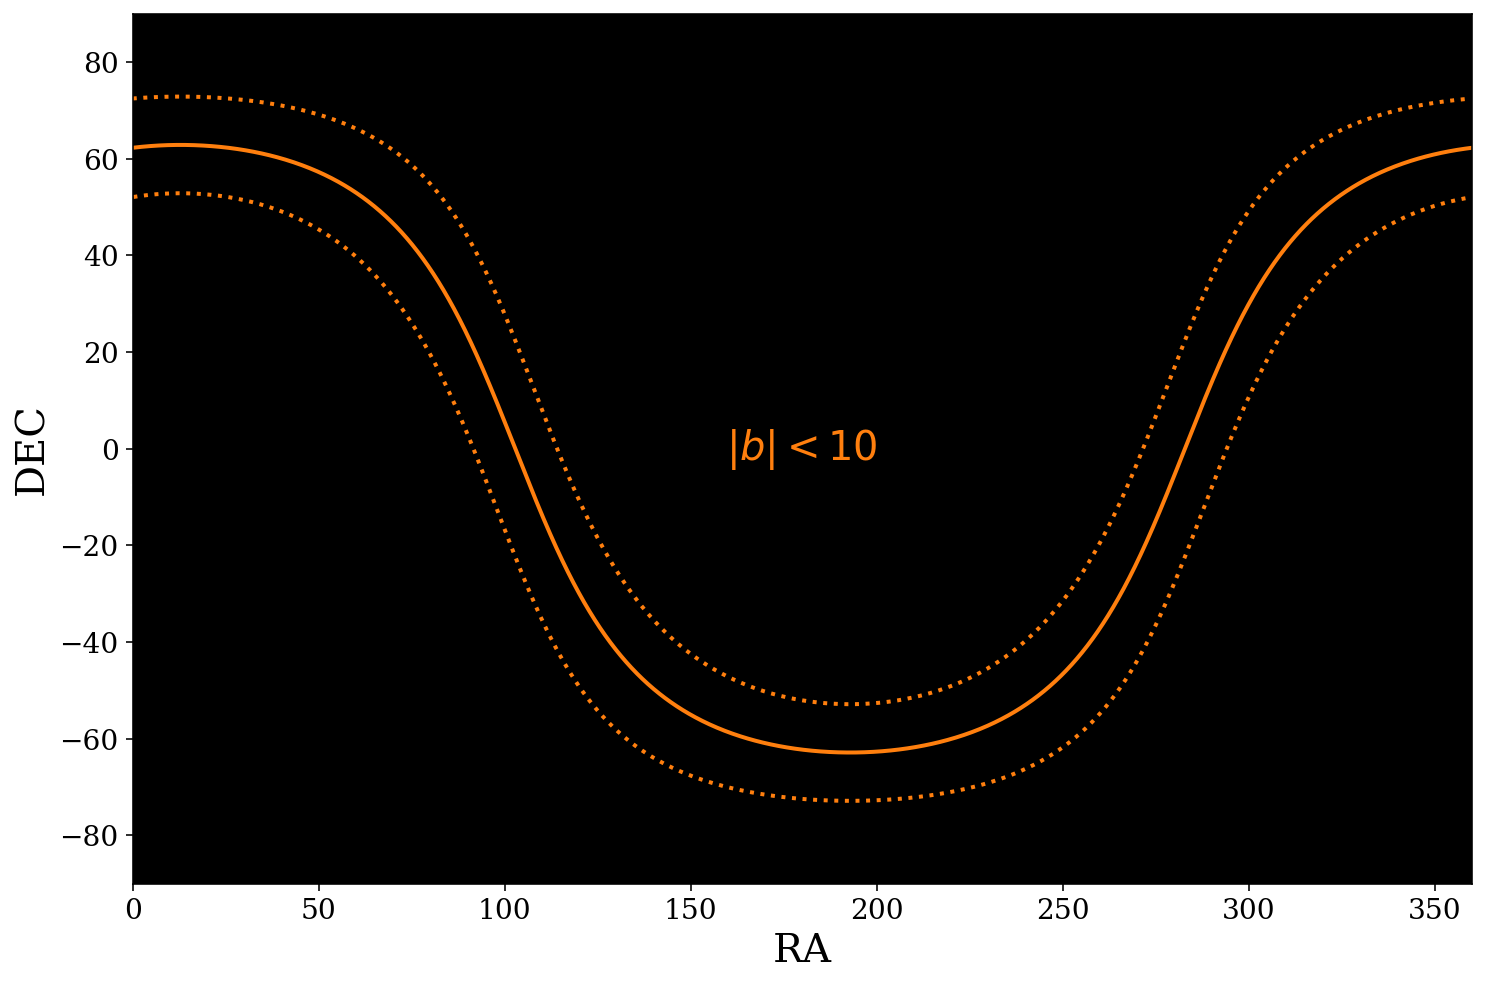

In [14]:
for sign in [-1, 0, 1]:
    print(b * sign)
    x = SkyCoord(l=l, b=b * sign, frame="galactic").transform_to("icrs")
    ra = np.asarray(x.ra)
    dec = np.asarray(x.dec)
    
    order = np.argsort(ra)
    ra = ra[order]
    dec = dec[order]
    
    print(dec)
    
    plt.plot(ra, dec, lw=2, color="tab:orange", linestyle="dotted" if sign != 0 else "-")
    
plt.annotate(r"$\vert b \vert < 10$", xy=(180, 0), color="tab:orange", fontsize=20, ha="center", va="center")

plt.xlim(0, 360)
plt.ylim(-90,90)

plt.xlabel("RA")
plt.ylabel("DEC")

plt.gca().set_facecolor("black")

plt.show()

In [467]:
l = np.linspace(0, 2 * np.pi, 100000)

bs = ([-10, 10] * u.deg).to(u.rad)
limits = np.zeros((2, len(l)))
ras = np.zeros((2, len(l)))

for i, b in enumerate(bs):
    galactic = SkyCoord(l=l, b=np.repeat(b, len(l)), frame="galactic", unit="rad")
    icrs = galactic.transform_to("icrs")

    ra = icrs.ra.to(u.rad)
    dec = icrs.dec.to(u.rad)

    order = np.argsort(ra)
    ra = ra[order]
    dec = dec[order]
    
    print(ra)
    
    limits[i] = dec
    ras[i] = ra

[5.54753e-05rad 0.000154091rad 0.00025271rad ... 6.28294rad 6.28304rad
 6.28314rad]
[2.53063e-05rad 0.000226675rad 0.000428059rad ... 6.28261rad 6.28281rad
 6.28301rad]


In [380]:
from scipy.interpolate import interp1d

In [468]:
lower = interp1d(ras[0], limits[0])
upper = interp1d(ras[-1], limits[-1])

In [469]:
def integrand(a):    
    return np.sin(upper(a)) - np.sin(lower(a))

In [470]:
from scipy.integrate import quad

In [471]:
(quad(integrand, 0, 2 * np.pi)[0] * u.rad**2).to(u.deg**2)

<Quantity 7163.50154307 deg2>

# Sensitivity curve plots

In [11]:
fid_sources = [None, None, None]
for i in range(len(dco_types)):
    with h5.File(sim_folder + "{}_fiducial_all.h5".format(dco_types[i]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] > 7
        
        data = full_data[snr_mask]
        
    fid_sources[i] = legwork.source.Source(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                dist=data["dist"] * u.kpc, ecc=data["e_LISA"],
                                                a=data["a_LISA"] * u.AU)
    fid_sources[i].weight = data["weight"]

In [12]:
for i in range(len(dco_types)):
    fid_sources[i].get_snr(verbose=True)

Calculating SNR for 46424 sources
	46421 sources are stationary
		30416 sources are stationary and circular
		16005 sources are stationary and eccentric
	3 sources are evolving
		3 sources are evolving and circular
Calculating SNR for 44927 sources
	44925 sources are stationary
		41843 sources are stationary and circular
		3082 sources are stationary and eccentric
	2 sources are evolving
		2 sources are evolving and circular
Calculating SNR for 32805 sources
	32803 sources are stationary
		18591 sources are stationary and circular
		14212 sources are stationary and eccentric
	2 sources are evolving
		2 sources are evolving and circular


In [14]:
def plot_sc_with_dist_lines(frequency_range, fig, ax, mc_mean, mc_min, line_scale=1, line_rot=10, loc=-75):
    legwork.visualisation.plot_sensitivity_curve(show=False, frequency_range=frequency_range, fig=fig, ax=ax)
    
    times = np.logspace(0, -8, 9) * u.Gyr
    athings = np.power(4 * legwork.utils.beta(mc_min * 2**(1/5), mc_min * 2**(1/5)) * times, 1/4)
    freqs = legwork.utils.get_f_orb_from_a(a=athings, m_1=mc_min * 2**(1/5), m_2=mc_min * 2**(1/5))
    hide_height = np.sqrt(legwork.psd.lisa_psd(freqs))
    
    for i in range(len(times)):
        ax.plot([freqs[i].value, freqs[i].value], [hide_height[i].value, 1e-13],
                color="grey", lw=line_scale, zorder=0, linestyle="dotted")
        ax.annotate(r"$10^{{{0:1.0f}}}$ yr".format(np.log10(times[i].to(u.yr).value)), xy=(freqs[i].value, 7.5e-14),
                    va="top", ha="center", rotation=90, fontsize=10 * line_scale, color="grey",
                    bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))
        
    line_length = 1000
    lines_f_range = np.logspace(-6.5, -1.4, line_length) * u.Hz
    for dist in [0.1, 0.5, 8, 30]:
        dist_line_signal = np.sqrt(4 * u.yr).to(u.Hz**(-1/2))\
            * legwork.strain.h_0_n(m_c=np.repeat(mc_mean, line_length),
                                   dist=np.repeat(dist, line_length) * u.kpc, 
                                   f_orb=lines_f_range,
                                   n=2,
                                   ecc=np.zeros(line_length))[:, 0, 0]
        mask = dist_line_signal > np.sqrt(legwork.psd.lisa_psd(lines_f_range * 2))
        ax.plot(lines_f_range[mask] * 2, dist_line_signal[mask], color="grey", linestyle="dotted", zorder=0, lw=line_scale)
        ax.annotate("{} kpc".format(dist), xy=(lines_f_range[mask][-20].value, dist_line_signal[mask][-20].value * (0.45 + line_scale / 20)), xycoords="data", color="grey", rotation=line_rot * 1.2, 
                         ha="right", va="center", fontsize=10 * line_scale, bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))
        
    for e_dist_line in [0.98]:
        nmax = 220 if e_dist_line == 0.9 else 1500
        e_sources = legwork.source.Stationary(dist=np.repeat(dist, line_length) * u.kpc,
                                          ecc=np.repeat(e_dist_line, line_length),
                                          f_orb=lines_f_range,
                                          m_1=np.repeat(mc_min * 2**(1/5), line_length),
                                          m_2=np.repeat(mc_min * 2**(1/5), line_length))
        e_sources.get_snr()
        dominant_freq = lines_f_range * e_sources.max_snr_harmonic
        e_dist_line_signal = e_sources.snr * np.sqrt(legwork.psd.lisa_psd(dominant_freq))
        check = np.argmin(np.diff(dominant_freq))
        mask = e_sources.snr[:check] > 1
        ax.plot(dominant_freq[:check][mask], e_dist_line_signal[:check][mask], lw=line_scale, zorder=0, color="grey", linestyle="dotted")

    ax.annotate("{} kpc, e={}".format(dist, e_dist_line), xy=(dominant_freq[:check][mask][loc].value, e_dist_line_signal[:check][mask][loc].value), xycoords="data", color="grey",
                     rotation=line_rot * 1.1, ha="center", va="center", fontsize=10 * line_scale, bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))
    
    ax.annotate(r"$\langle \mathcal{{M}}_c \rangle = {{{0:1.1f}}} \, M_{{\odot}}$".format(mc_mean.value), xy=(1e-2, 3e-20), ha="center", va="center", 
                fontsize=12 * line_scale, bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))
    
    return fig, ax

full done
BHBH done
BHNS done
NSNS done


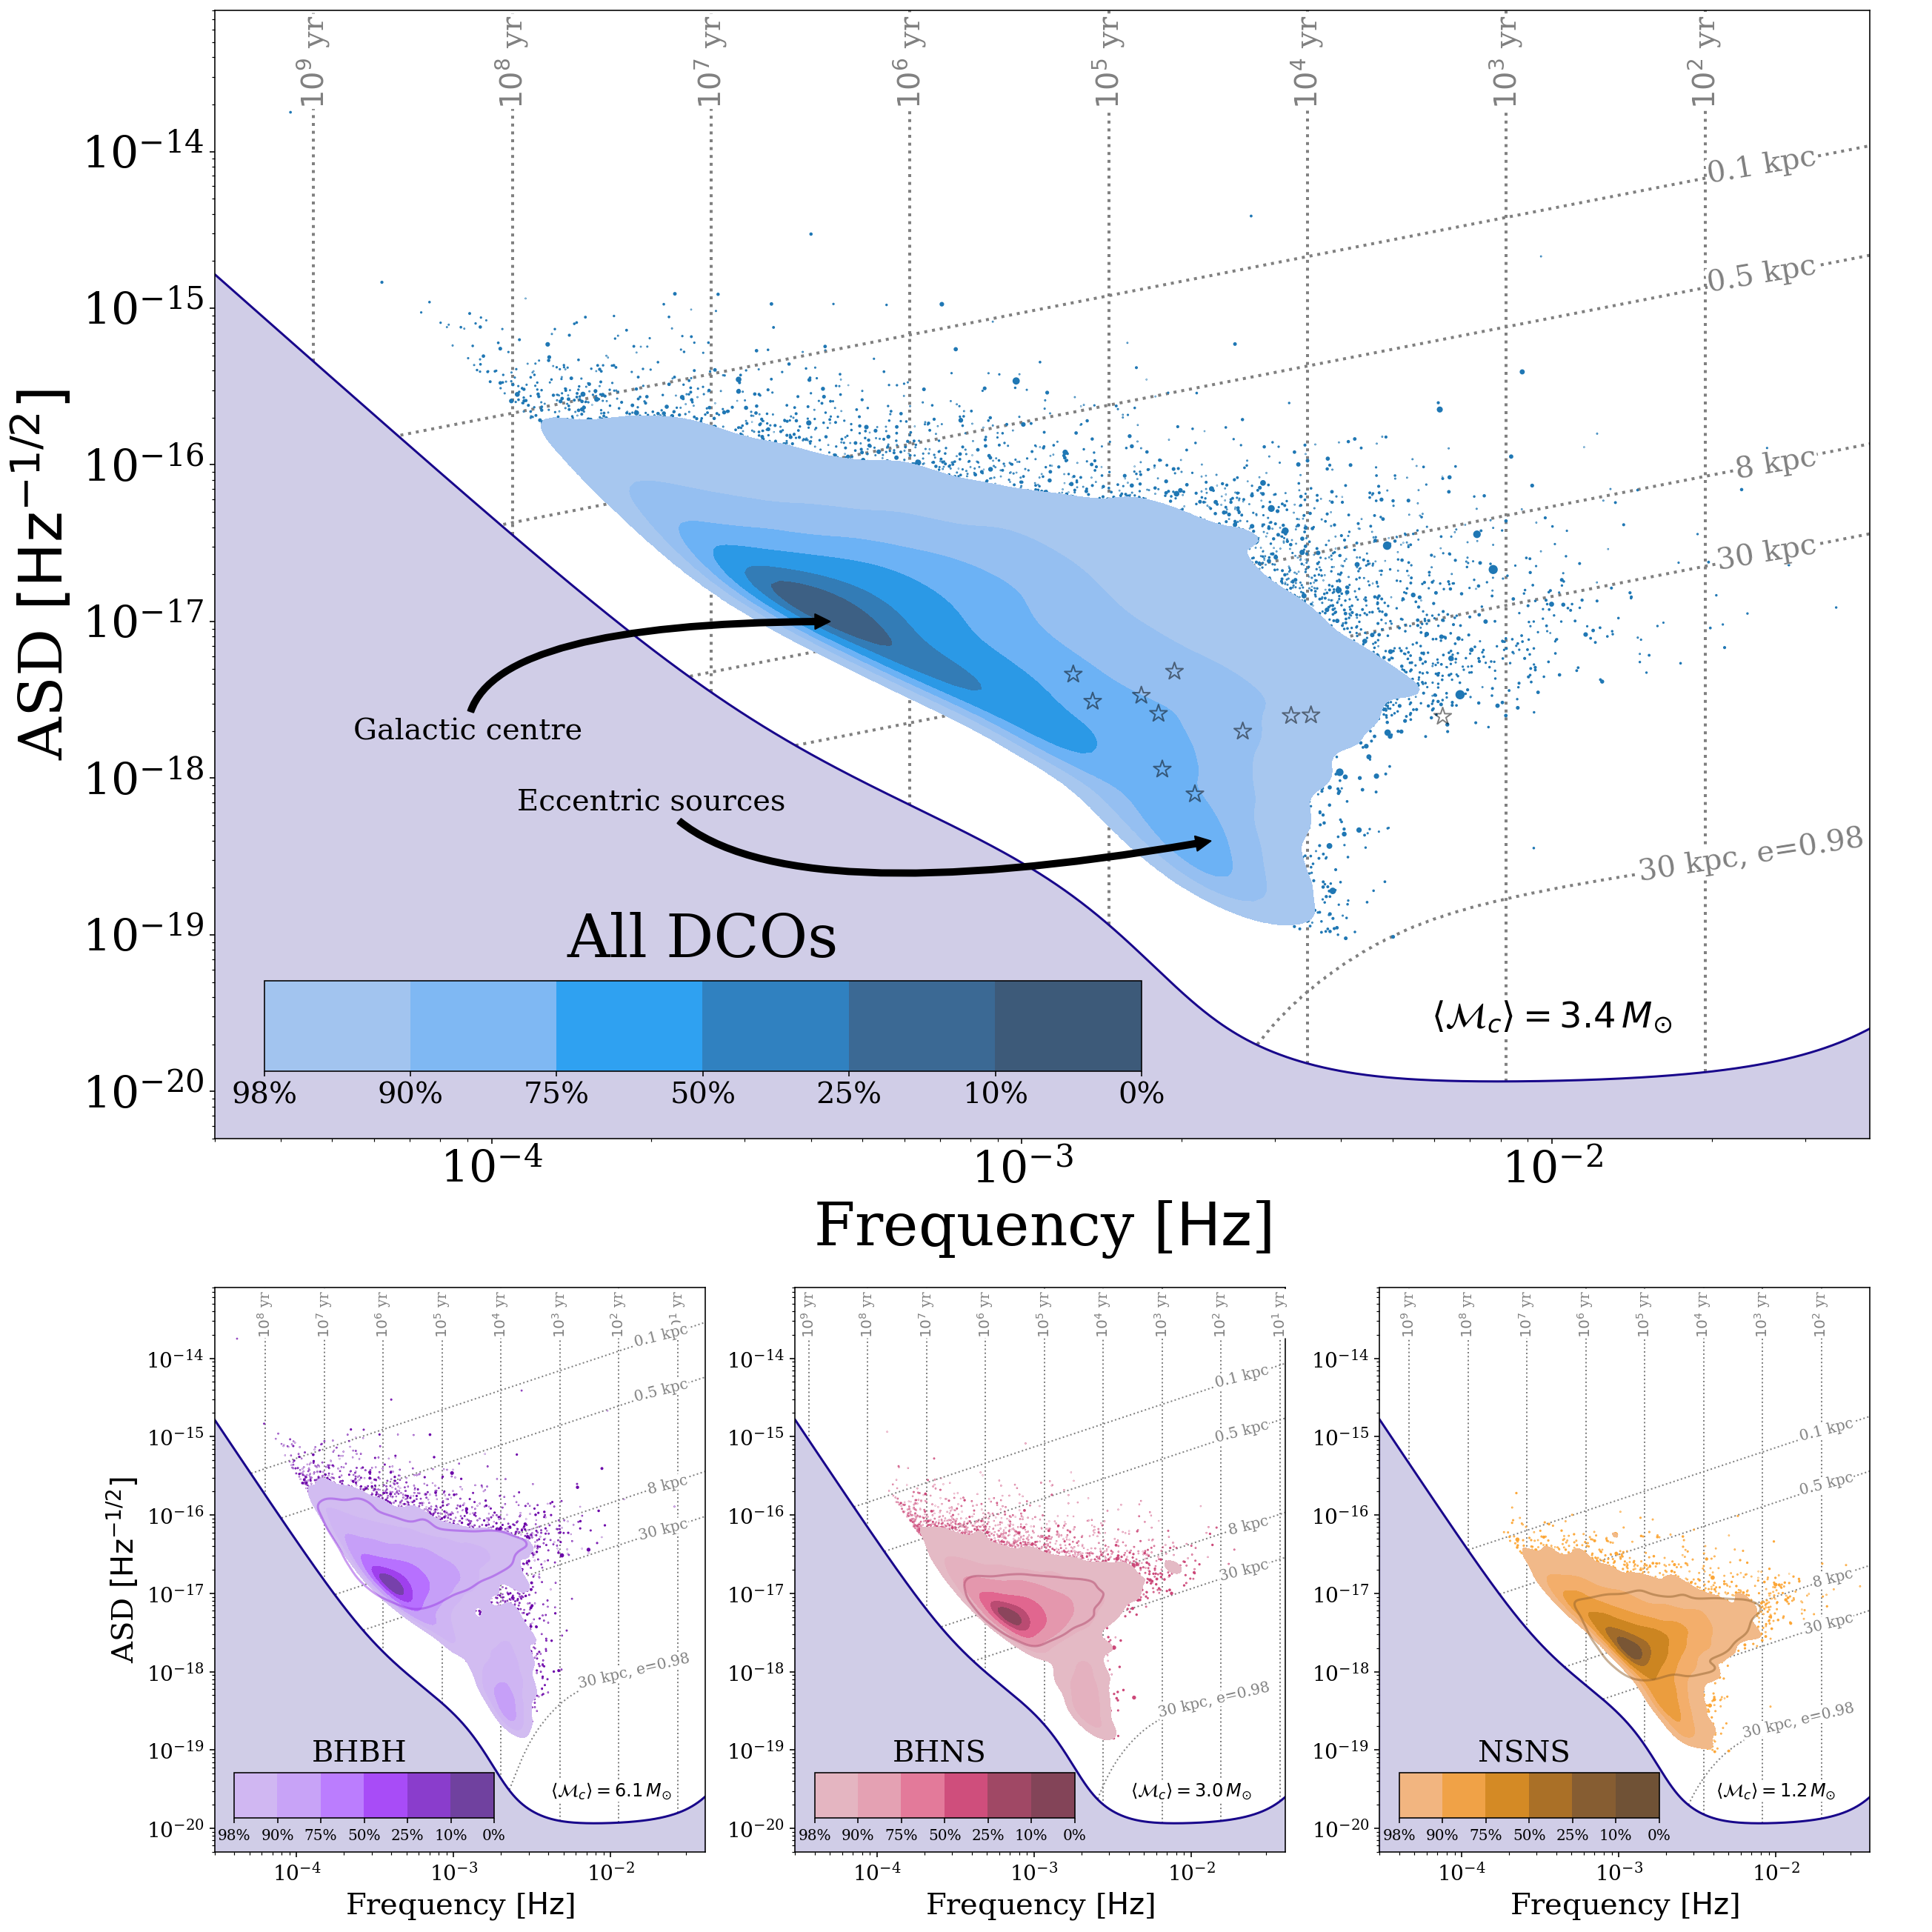

In [36]:
frequency_range = np.logspace(np.log10(3e-5), -1.4, 1000) * u.Hz

fig = plt.figure(figsize=(18, 18), constrained_layout=True)

gs = GridSpec(2, 3, figure=fig, height_ratios=(2, 1))
all_ax = fig.add_subplot(gs[0, :])
axes = [fig.add_subplot(gs[1, i]) for i in range(3)]
levels = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
level_labels = ["98%", "90%", "75%", "50%", "25%", "10%", "0%"]

all_mc_mean = np.mean([fid_sources[i].m_c.mean().value for i in range(len(fid_sources))]) * u.Msun
all_mc_min = np.min([fid_sources[i].m_c.min().value for i in range(len(fid_sources))]) * u.Msun
fig, all_ax = plot_sc_with_dist_lines(frequency_range, fig=fig, ax=all_ax,
                                      mc_mean=all_mc_mean,
                                      mc_min=all_mc_min,
                                      line_scale=2, line_rot=8, loc=-10)

all_f_dom = np.concatenate([fid_sources[i].f_orb * fid_sources[i].max_snr_harmonic for i in range(len(fid_sources))])
all_snr = np.concatenate([fid_sources[i].snr for i in range(len(fid_sources))])
all_weight = np.concatenate([fid_sources[i].weight for i in range(len(fid_sources))])
all_ecc = np.concatenate([fid_sources[i].ecc for i in range(len(fid_sources))])

legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=all_f_dom, snr=all_snr, fig=fig, ax=all_ax,
                                                  show=False, color="tab:blue", s=all_weight * 25) #fid_sources[i].ecc

all_ax.annotate("Galactic centre",
                xy=(4.4e-4, 1e-17), xycoords='data',
                xytext=(9e-5, 2e-18), textcoords='data',
                arrowprops=dict(arrowstyle="simple", color="black",
                                connectionstyle="angle3,angleA=90,angleB=0"),
                fontsize=fs, ha="center", va="center")

all_ax.annotate("Eccentric sources",
                xy=(2.3e-3, 4e-19), xycoords='data',
                xytext=(2e-4, 7e-19), textcoords='data',
                arrowprops=dict(arrowstyle="simple", color="black",
                                connectionstyle="angle3,angleA=120,angleB=10", relpos=(0.5, 1.0)),
                fontsize=fs, ha="center", va="center")

f_GWs = [vb["f_GW"].to(u.Hz).value for vb in verification_binaries if vb["snr"] > 7]
ASDs = [(legwork.psd.lisa_psd(vb["f_GW"])**(0.5) * vb["snr"]).to(u.Hz**(-1/2)).value for vb in verification_binaries if vb["snr"] > 7]
all_ax.scatter(f_GWs, ASDs, s=150, facecolor="none", edgecolor="black", marker="*", alpha=0.5,
               label="Verification binaries", zorder=10)

# the lazy man's guide to colorbars: just plot hidden points
cmap = cmap_from_colour("tab:blue")
scatter = all_ax.scatter(np.ones_like(levels) * 1e-5, np.ones_like(levels) * 1e-21, c=levels, cmap=cmap)
inset_all_ax = all_ax.inset_axes([0.03, 0.06, 0.53, 0.08])
cbar = fig.colorbar(scatter, ax=all_ax, cax=inset_all_ax, boundaries=levels, orientation="horizontal")
cbar.set_ticklabels(level_labels)
cbar.ax.tick_params(labelsize=fs)

all_ax.annotate("All DCOs", xy=(0.295, 0.15), xycoords="axes fraction", fontsize=2 * fs, color="black", ha="center", va="bottom")

legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=all_f_dom, snr=all_snr, fig=fig, ax=all_ax,
                                                  show=False, color="tab:blue", weights=all_weight,
                                                  disttype="kde", fill=True, levels=levels)

print("full done")

for i, dco_type in enumerate(dco_types):
    fig, axes[i] = plot_sc_with_dist_lines(frequency_range, fig=fig, ax=axes[i],
                                           mc_mean=fid_sources[i].m_c.mean(),
                                           mc_min=fid_sources[i].m_c.min(), line_rot=12, loc=-105)
    
    # the lazy man's guide to colorbars: just plot hidden points
    cmap = cmap_from_colour(dco_colours[dco_types[i]])
    scatter = axes[i].scatter(np.ones_like(levels) * 1e-5, np.ones_like(levels) * 1e-21, c=levels, cmap=cmap)
    inset_ax = axes[i].inset_axes([0.04, 0.06, 0.53, 0.08])
    cbar = fig.colorbar(scatter, ax=axes[i], cax=inset_ax, boundaries=levels, orientation="horizontal")
    cbar.set_ticklabels(level_labels)
    cbar.ax.tick_params(labelsize=10)
    
    f_dom = fid_sources[i].f_orb * fid_sources[i].max_snr_harmonic
    legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=f_dom,
                                                      snr=fid_sources[i].snr, fig=fig, ax=axes[i], show=False,
                                                      color=dco_colours[dco_types[i]], s=fid_sources[i].weight / fid_sources[i].weight.sum() * 1e4)
    
    legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=f_dom,
                                                      snr=fid_sources[i].snr, fig=fig, ax=axes[i], show=False,
                                                      color=dco_colours[dco_types[i]], weights=fid_sources[i].weight,
                                                      disttype="kde", fill=True, levels=levels,
                                                      bw_adjust=0.8 if i == 0 else 1.0 if i == 1 else 0.9)
    
    mask = fid_sources[i].ecc < 0.01
    color = list(cmap(0.75))
    color[-1] = 0.5
    legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=f_dom[mask], snr=fid_sources[i].snr[mask],
                                                      fig=fig, ax=axes[i], show=False, color=tuple(color),
                                                      weights=fid_sources[i].weight[mask], disttype="kde",
                                                      fill=False, levels=[0.1],
                                                      bw_adjust=0.8 if i == 0 else 1.0 if i == 1 else 0.9)

    axes[i].annotate(dco_types[i], xy=(0.295, 0.15), xycoords="axes fraction",
                     fontsize=fs, color="black", ha="center", va="bottom")
    
    print(dco_types[i], "done")

ylims = (5e-21, 8e-14)
    
for ax in [all_ax] + axes:
    if ax in axes[1:]:
        ax.set_ylabel("")
    ax.set_ylim(ylims)
    
all_ax.tick_params(labelsize=1.5 * fs)
all_ax.xaxis.label.set_fontsize(2 * fs)
all_ax.yaxis.label.set_fontsize(2 * fs)

plt.savefig("../../paper/figures/dcos_on_sc.png", dpi=300, bbox_inches="tight")
plt.savefig("../../paper/figures/dcos_on_sc_high_res.png", dpi=600, bbox_inches="tight")

# plt.savefig("../../paper/figures/dcos_on_sc_alt.png", dpi=300, bbox_inches="tight")
# plt.savefig("../../paper/figures/dcos_on_sc_high_res_alt.png", dpi=600, bbox_inches="tight")

plt.show()

In [32]:
fid_sources[0].weight.mean() / fid_sources[0].weight.sum()

2.1540582457349645e-05

In [33]:
fid_sources[1].weight.mean() / fid_sources[1].weight.sum()

2.2258330180069893e-05

In [34]:
fid_sources[2].weight.mean() / fid_sources[2].weight.sum()

3.0483158055174515e-05

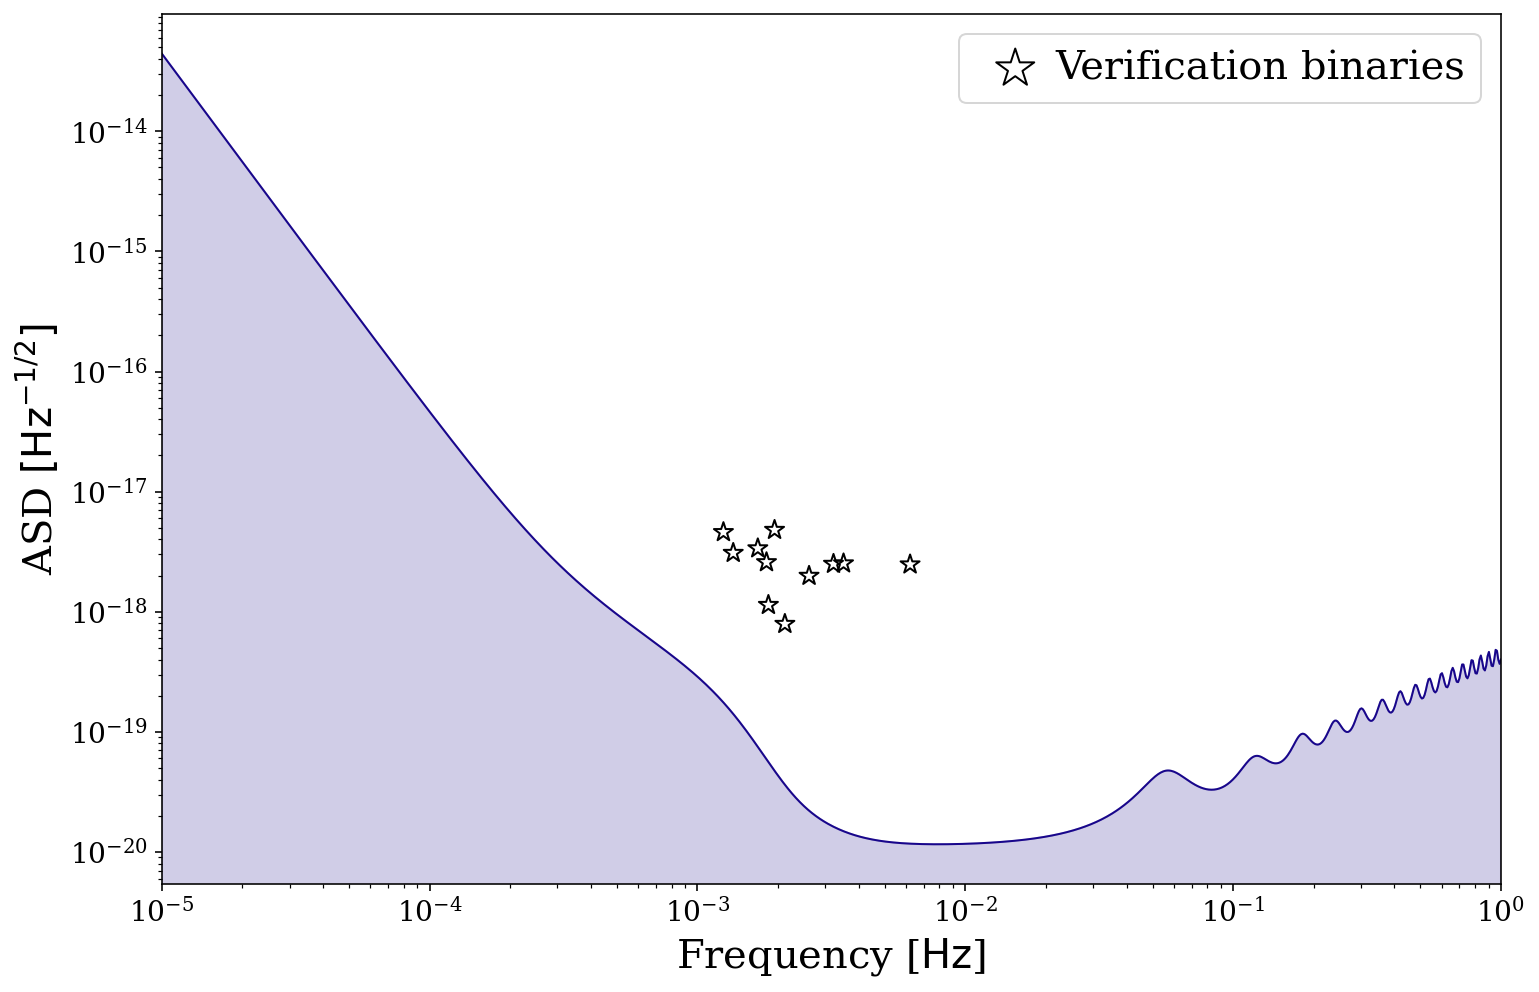

In [105]:
fig, ax = legwork.visualisation.plot_sensitivity_curve(show=False, frequency_range=np.logspace(-5, 0, 1000) * u.Hz)

f_GWs = [vb["f_GW"].to(u.Hz).value for vb in verification_binaries]
ASDs = [(legwork.psd.lisa_psd(vb["f_GW"])**(0.5) * vb["snr"]).to(u.Hz**(-1/2)).value for vb in verification_binaries]
ax.scatter(f_GWs, ASDs, s=100, facecolor="none", edgecolor="black", marker="*", label="Verification binaries")
    
ax.legend(handletextpad=0.0, markerscale=2.0)

plt.show()

In [90]:
fid_sources[0].weight.mean()

0.10389711058111946

In [91]:
fid_sources[1].weight.mean()

0.0247229066264333

In [92]:
fid_sources[2].weight.mean()

0.036100087298277385

# Tau-Z stuff (TODO)

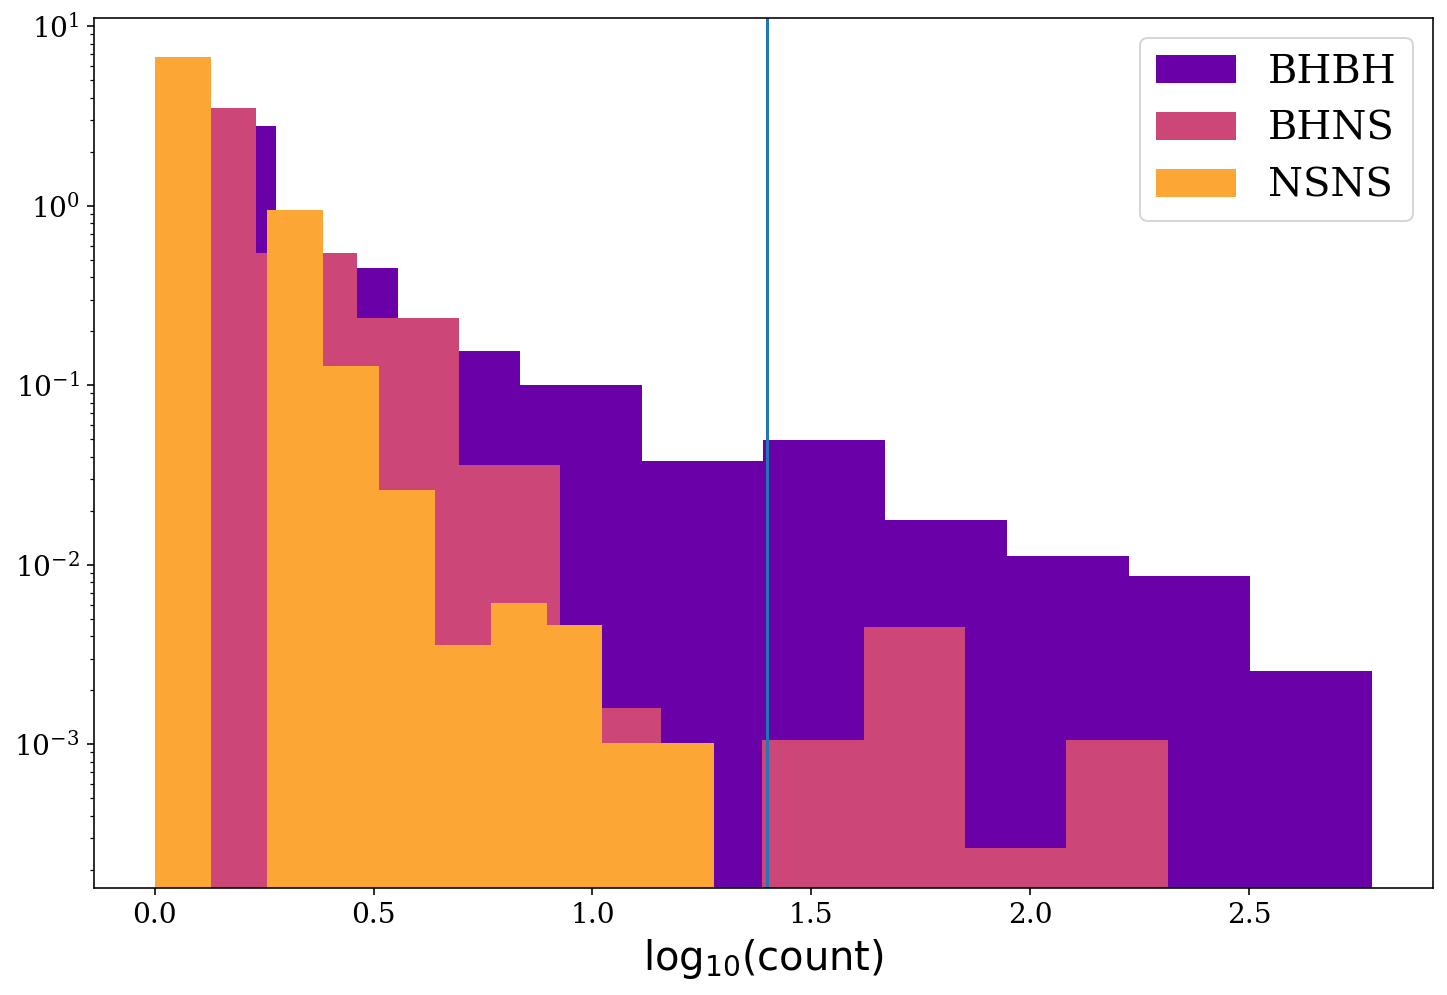

In [214]:
t_obs = 4 * u.yr
for dco_type in ["BHBH", "BHNS", "NSNS"]:
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[0]["file"]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

        data = full_data[snr_mask]
        
    uniques, counts = np.unique(data["seed"], return_counts=True)
    
    plt.hist(np.log10(counts), density=True, log=True, color=dco_colours[dco_type], label=dco_type)

plt.legend()

plt.xlabel(r"$\log_{10} (\rm count)$")

plt.axvline(np.log10(25))

plt.show()

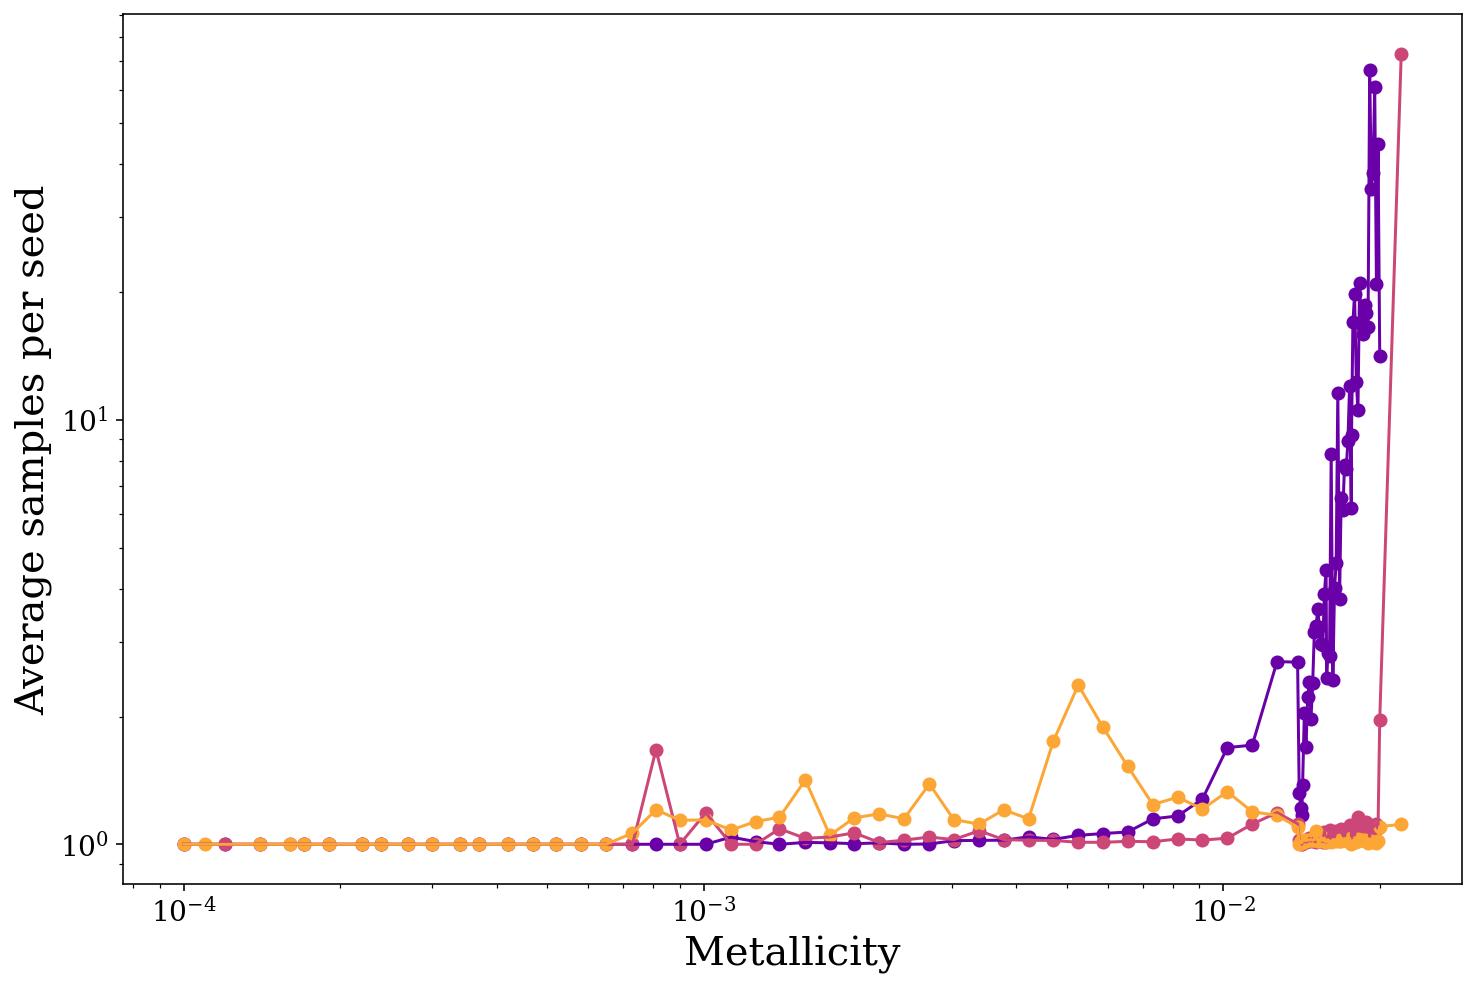

In [53]:
t_obs = 4 * u.yr
for dco_type in ["BHBH", "BHNS", "NSNS"]:
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[0]["file"]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

        data = full_data[snr_mask]
        
    uniques, ind, counts = np.unique(data["seed"], return_index=True, return_counts=True)
    
#     plt.scatter(data["Z"][ind], counts, color=dco_colours[dco_type])
    
    unique_Z = np.unique(data["Z"])
    means = np.zeros(len(unique_Z))
    for i, Z in enumerate(unique_Z):
        mask = data["Z"][ind] == Z
        means[i] = np.average(counts[mask], weights=data["weight"][ind][mask])
#         plt.scatter(Z, counts[mask].min(), color=dco_colours[dco_type], marker="^")
#         plt.scatter(Z, counts[mask].max(), color=dco_colours[dco_type], marker="v")
    plt.scatter(unique_Z, means, color=dco_colours[dco_type])
    plt.plot(unique_Z, means, color=dco_colours[dco_type])
    
#     plt.hist(np.log10(counts), density=True, log=True, color=dco_colours[dco_type], label=dco_type)

# plt.legend()

# plt.xlabel(r"$\log_{10} (\rm count)$")

# plt.axvline(np.log10(25))

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Metallicity")
plt.ylabel("Average samples per seed")

plt.show()

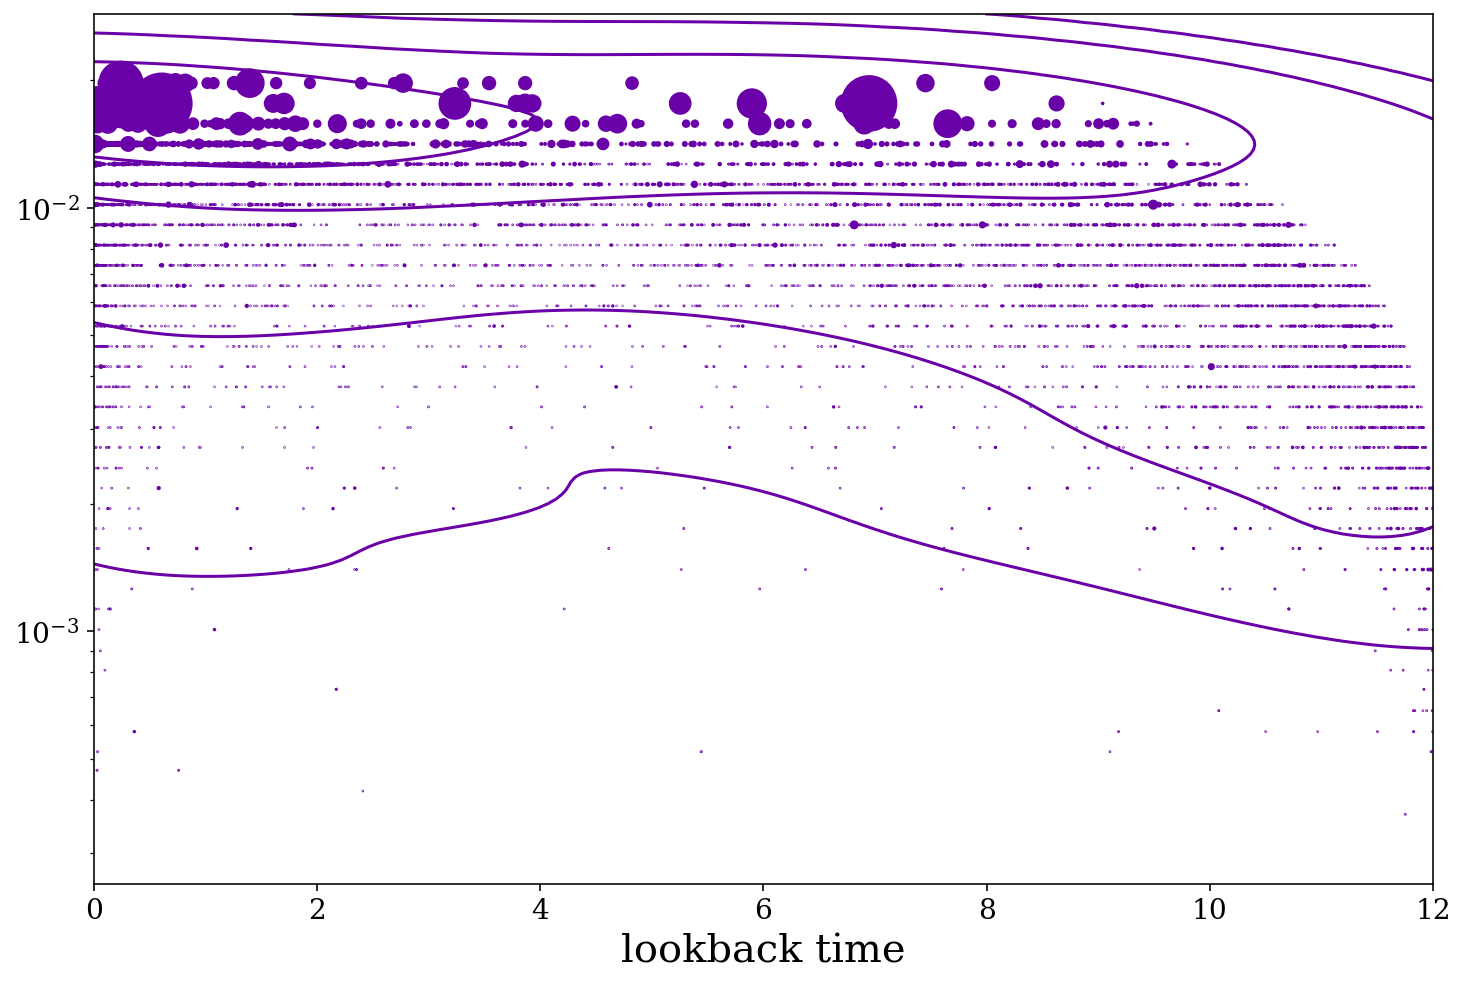

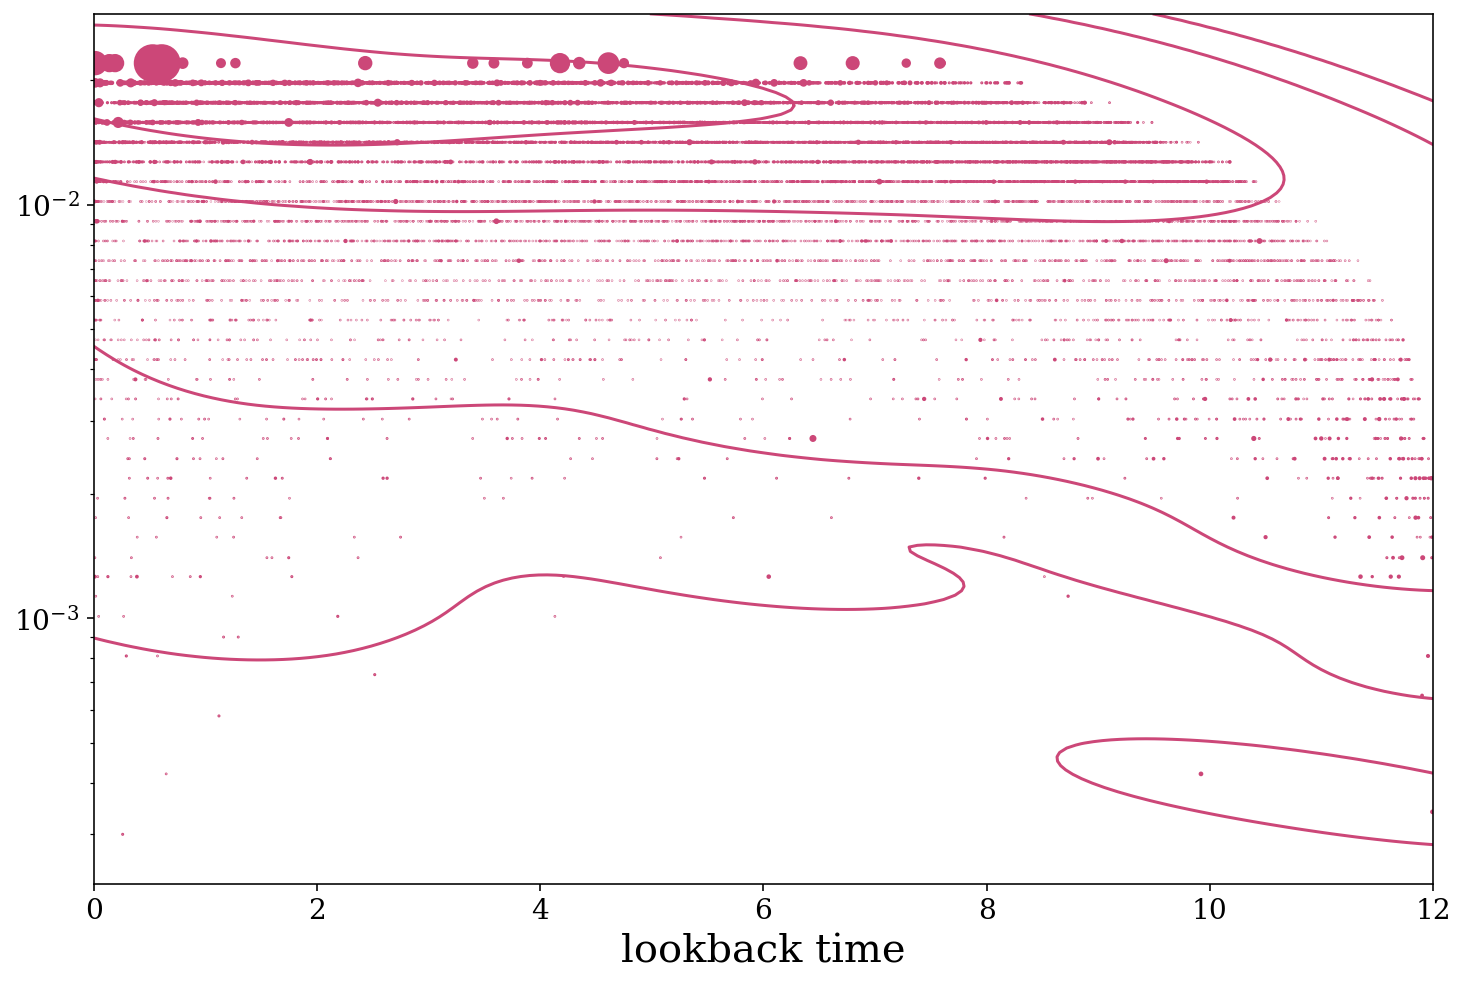

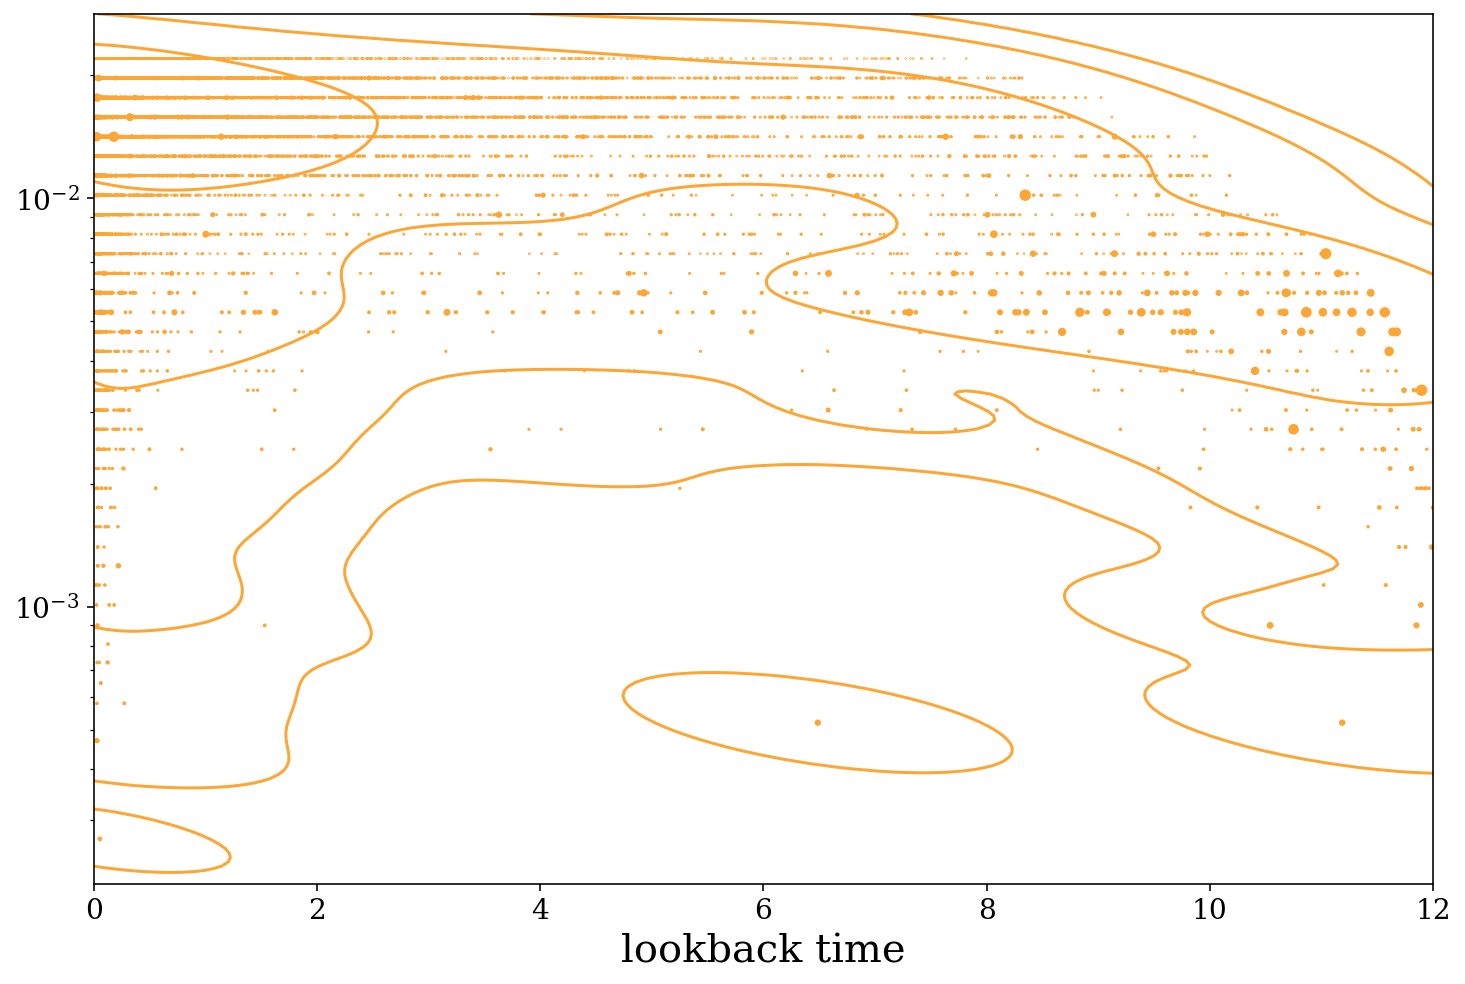

In [259]:
t_obs = 4 * u.yr
for dco_type in ["BHBH", "BHNS", "NSNS"]:
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[0]["file"]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

        data = full_data[snr_mask]
        
    # make everything unique and adjust weights
    _, uni_index, uni_count = np.unique(data["seed"],
                                        return_index=True, return_counts=True)
    data = data[uni_index]
    data["weight"] *= uni_count
        
    plt.scatter(data["tau"], data["Z"], s=data["weight"] * 10, color=dco_colours[dco_type])
    sns.kdeplot(x=data["tau"], y=data["Z"], weights=data["weight"], color=dco_colours[dco_type],
                log_scale=(False, True), levels=[0.001, 0.01, 0.1, 0.5])

    plt.xlabel("lookback time")
    plt.xlim(0, 12)
#     plt.yscale("log")
    plt.show()

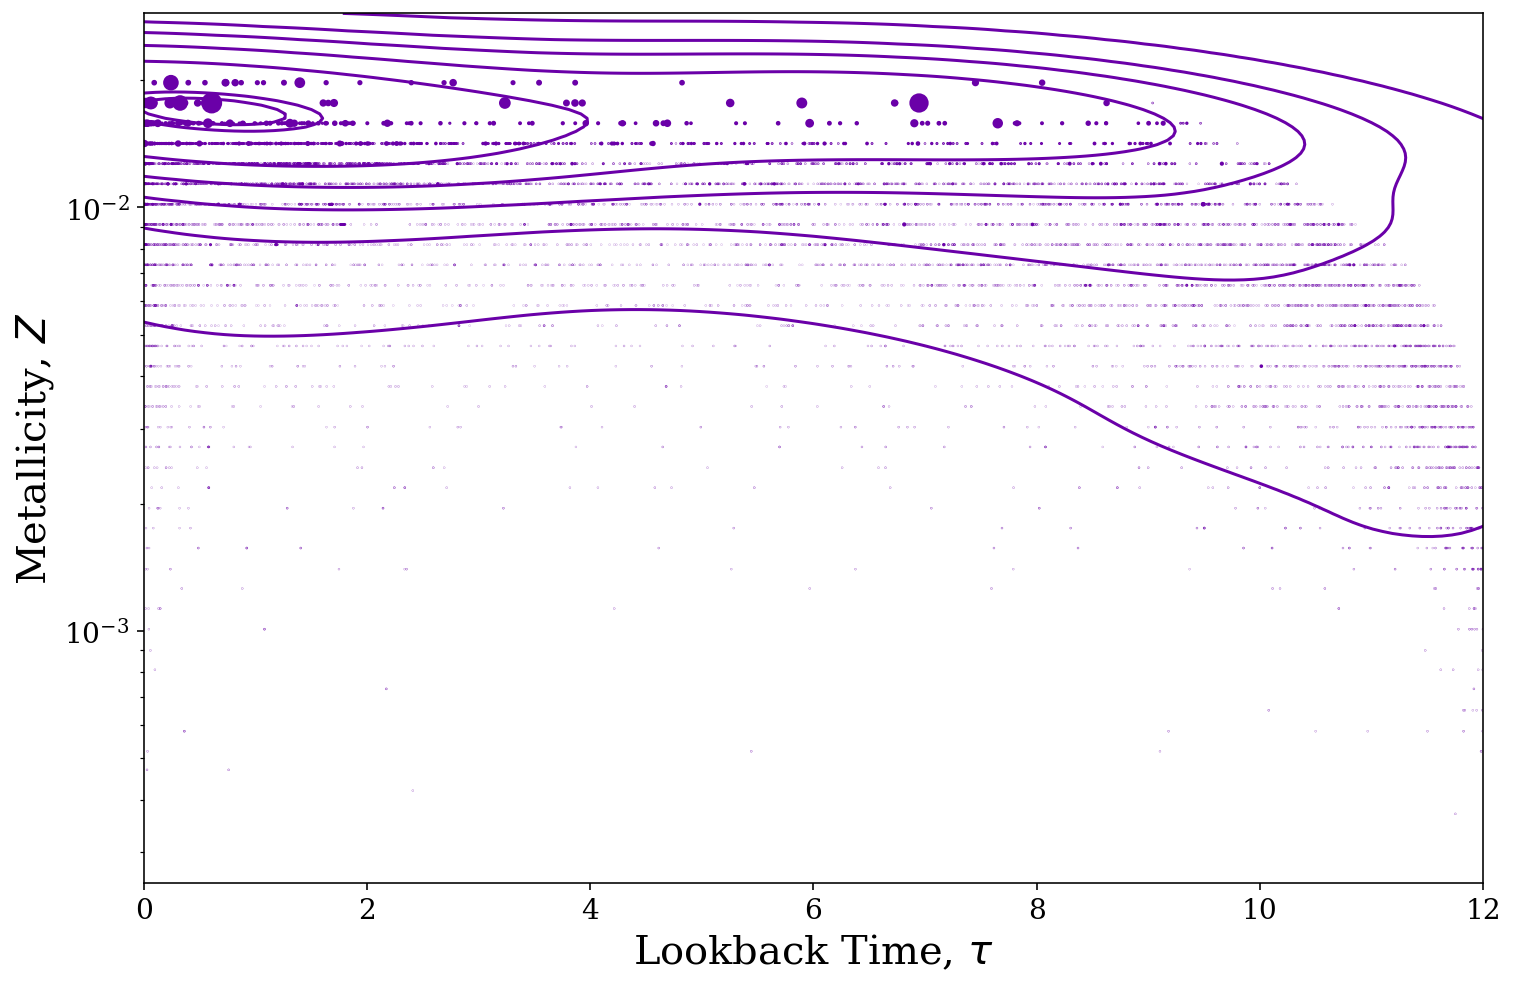

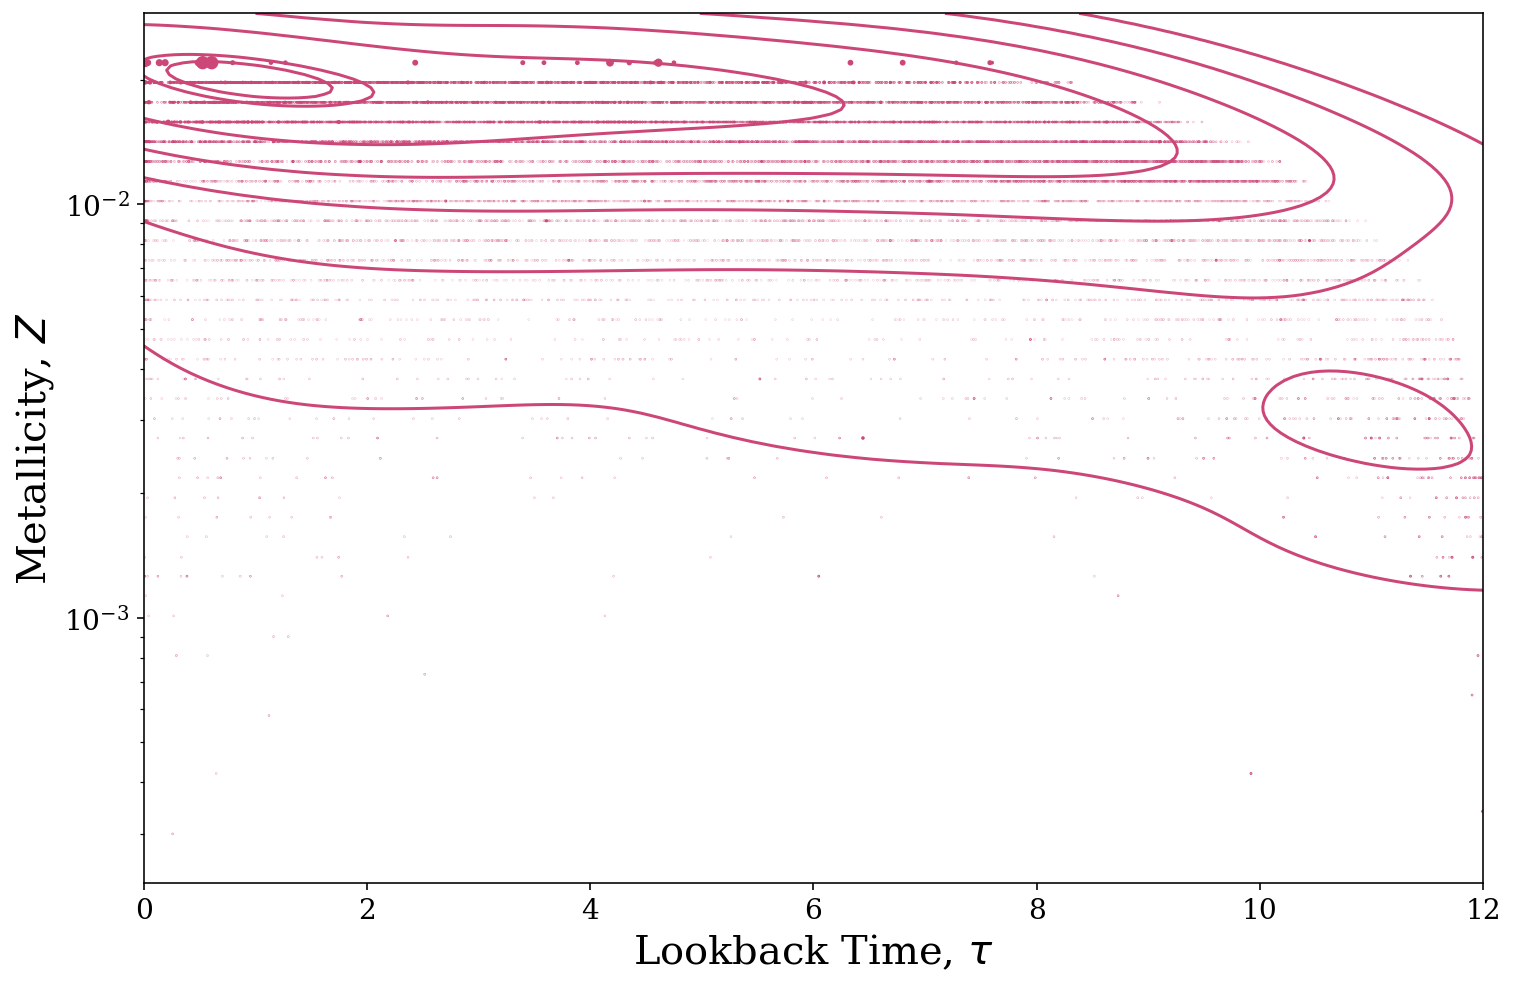

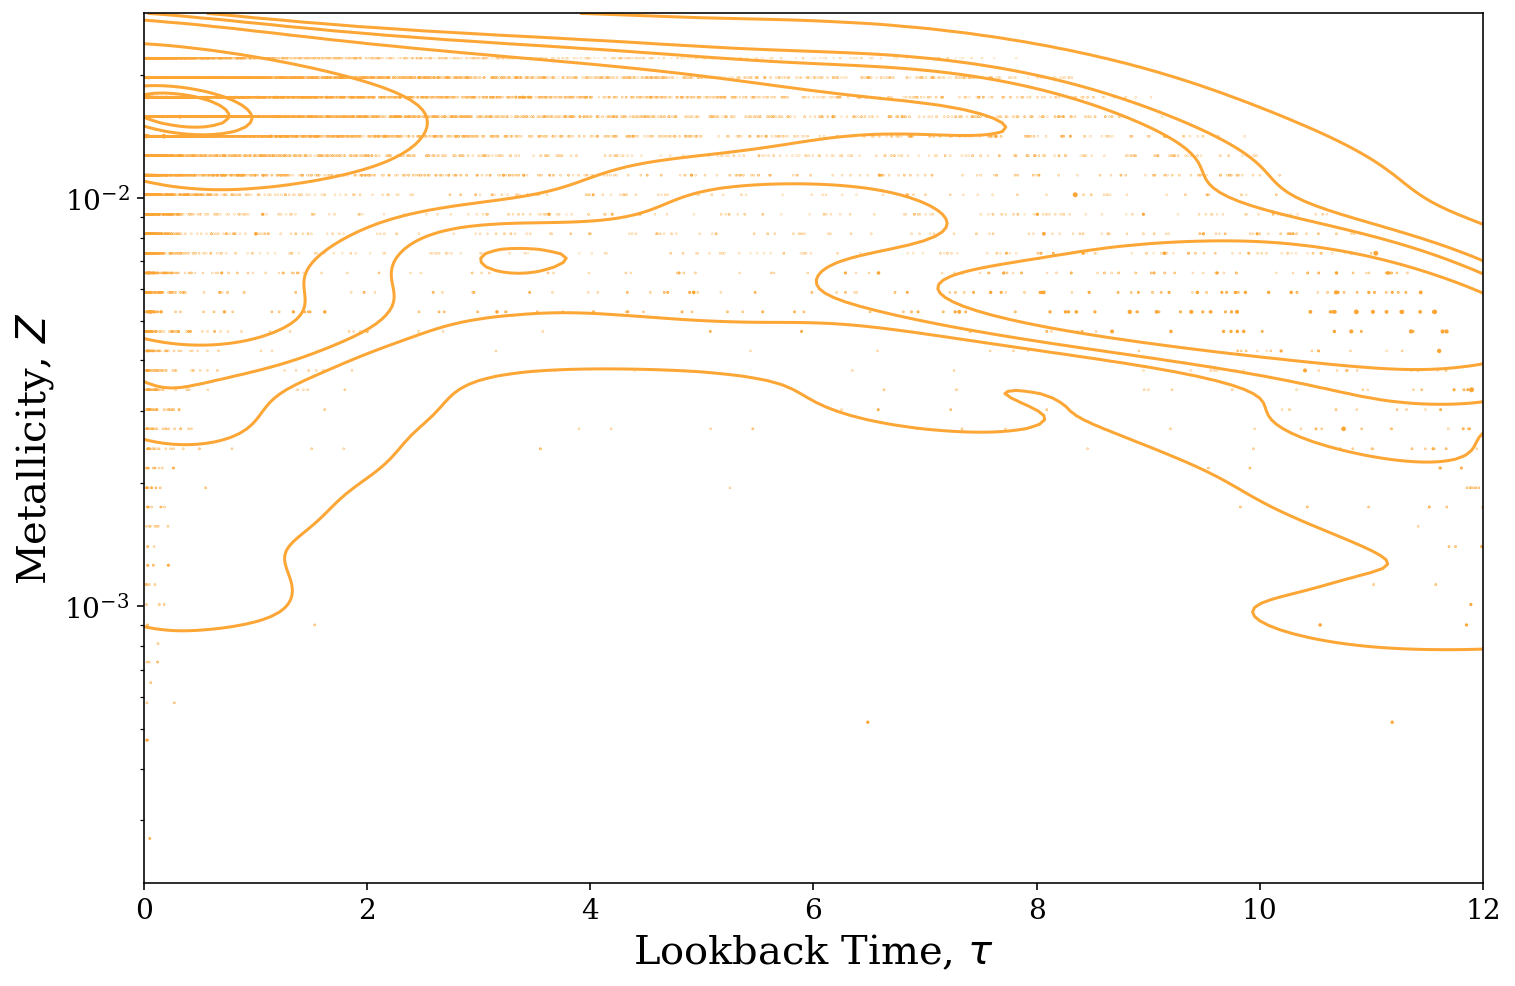

In [13]:
t_obs = 4 * u.yr
for dco_type in ["BHBH", "BHNS", "NSNS"]:
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[0]["file"]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

        data = full_data[snr_mask]
        
    # make everything unique and adjust weights
    _, uni_index, uni_count = np.unique(data["seed"],
                                        return_index=True, return_counts=True)
    data = data[uni_index]
    data["weight"] *= uni_count
        
    plt.scatter(data["tau"], data["Z"], s=data["weight"], color=dco_colours[dco_type])
    sns.kdeplot(x=data["tau"], y=data["Z"], weights=data["weight"], color=dco_colours[dco_type],
                log_scale=(False, True), levels=[0.01, 0.05, 0.1, 0.2, 0.5, 0.9, 0.95])

    plt.xlabel(r"Lookback Time, $\tau$")
    plt.ylabel(r"Metallicity, $Z$")
    plt.xlim(0, 12)
#     plt.yscale("log")
    plt.show()

In [5]:
t_obs = 4 * u.yr
for dco_type in ["BHBH", "BHNS", "NSNS"]:
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[0]["file"]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

        data = full_data[snr_mask]

# Mass distribution for simple MW

starting BHBH
mBH
starting BHNS
mBH
starting NSNS
mBH


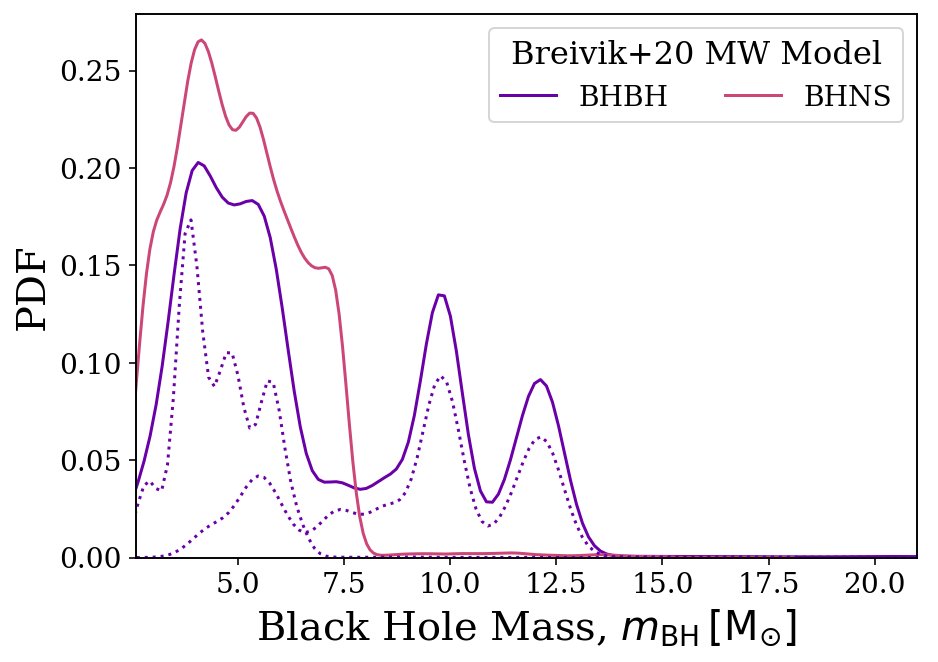

In [166]:
model = 0
t_obs = 4 * u.yr

fig, ax = plt.subplots(figsize=(7, 5))

lw = 4

for i, dco_type in enumerate(["BHBH", "BHNS", "NSNS"]):
    print("starting", dco_type)
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

        data = full_data[snr_mask]

    detection_total = detections_4yr if t_obs == 4 * u.yr else detections_10yr

    m_c = legwork.utils.chirp_mass(data["m_1"], data["m_2"]) * u.Msun
    f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                          a=data["a_LISA"] * u.AU)
    f_orb_dot = legwork.utils.fn_dot(m_c=m_c, f_orb=f_orb_LISA, e=data["e_LISA"], n=1)
    sigma_theta = sky_localisation(data["snr"], f_orb_LISA * max_harmonics[dco_type]).to(u.deg)

    D_Mc = get_m_c_uncertainty(f_orb_LISA * max_harmonics[dco_type], f_orb_dot * max_harmonics[dco_type],
                               data["e_LISA"], ecc_uncertainty[dco_type], data["snr"], t_obs).decompose()

    fake_seeds = np.linspace(0, len(data["seed"]), len(data["seed"]))    

    if dco_type == "BHNS":
        mBH = np.maximum(data["m_1"], data["m_2"])
        mNS = np.minimum(data["m_1"], data["m_2"])
        mass_weights = data["weight"]
        mass_seeds = data["seed"]
    elif dco_type == "BHBH":
        mBH = np.concatenate((data["m_1"], data["m_2"]))
        mass_weights = np.concatenate((data["weight"], data["weight"]))
        mass_seeds = np.concatenate((data["seed"], -1 * data["seed"]))
    elif dco_type == "NSNS":
        mNS = np.concatenate((data["m_1"], data["m_2"]))
        mass_weights = np.concatenate((data["weight"], data["weight"]))
        mass_seeds = np.concatenate((data["seed"], -1 * data["seed"]))

    print("mBH")

    if dco_type in ["BHNS", "BHBH"]:

        sns.kdeplot(mBH, weights=mass_weights, bw_adjust=1.4,
                    ax=ax, color=dco_colours[dco_type], label=dco_type)

        ax.set_xlabel(r"Black Hole Mass, $m_{\rm BH} \, [\rm M_{\odot}]$")
        ax.set_xlim(2.6, 21)

        if dco_type == "BHBH":
            ax_right = ax.twinx()
            sns.kdeplot(data["m_1"], weights=data["weight"], bw_adjust=1.4, ax=ax_right,
                        color=dco_colours[dco_type], label=dco_type, linestyle="dotted")
            sns.kdeplot(data["m_2"], weights=data["weight"], bw_adjust=1.4, ax=ax_right,
                        color=dco_colours[dco_type], label=dco_type, linestyle="dotted")

            ax_right.set_ylim(0, ax.get_ylim()[-1] * 4)
            ax_right.set_yticks([])
            ax_right.set_ylabel("")
            
ax.set_ylabel("PDF")

legend = ax.legend(title="Breivik+20 MW Model", fontsize=0.7*fs, ncol=2)
legend.get_title().set_fontsize(0.8*fs)

plt.savefig("../figures/BH_mass_dist_simple_mw.pdf", format="pdf", bbox_inches="tight")
        
plt.show()

# EAS plots

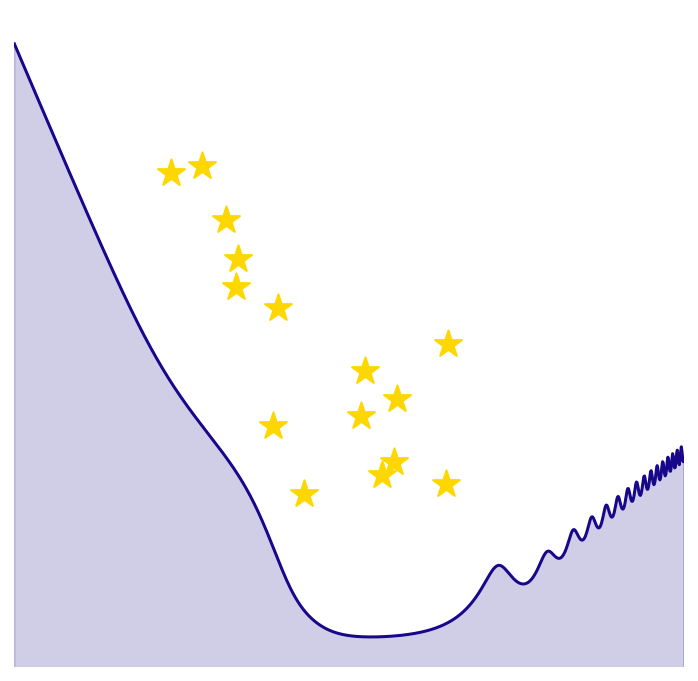

In [280]:
fig, ax = plt.subplots(figsize=(6, 6))

fig, ax = legwork.visualisation.plot_sensitivity_curve(frequency_range=np.logspace(-4.5, 0, 1000) * u.Hz,
                                                       fig=fig, ax=ax, show=False)

fs = 10**(np.random.uniform(-3.5, -1.5, 15)) * u.Hz
snrs = (1 - np.random.power(5, 15)) * 500 + 7
asds = np.sqrt(legwork.psd.lisa_psd(fs)) * snrs

ax.scatter(fs, asds, marker="*", s=200, color="gold")

ax.axis("off")

plt.show()

BHNS done


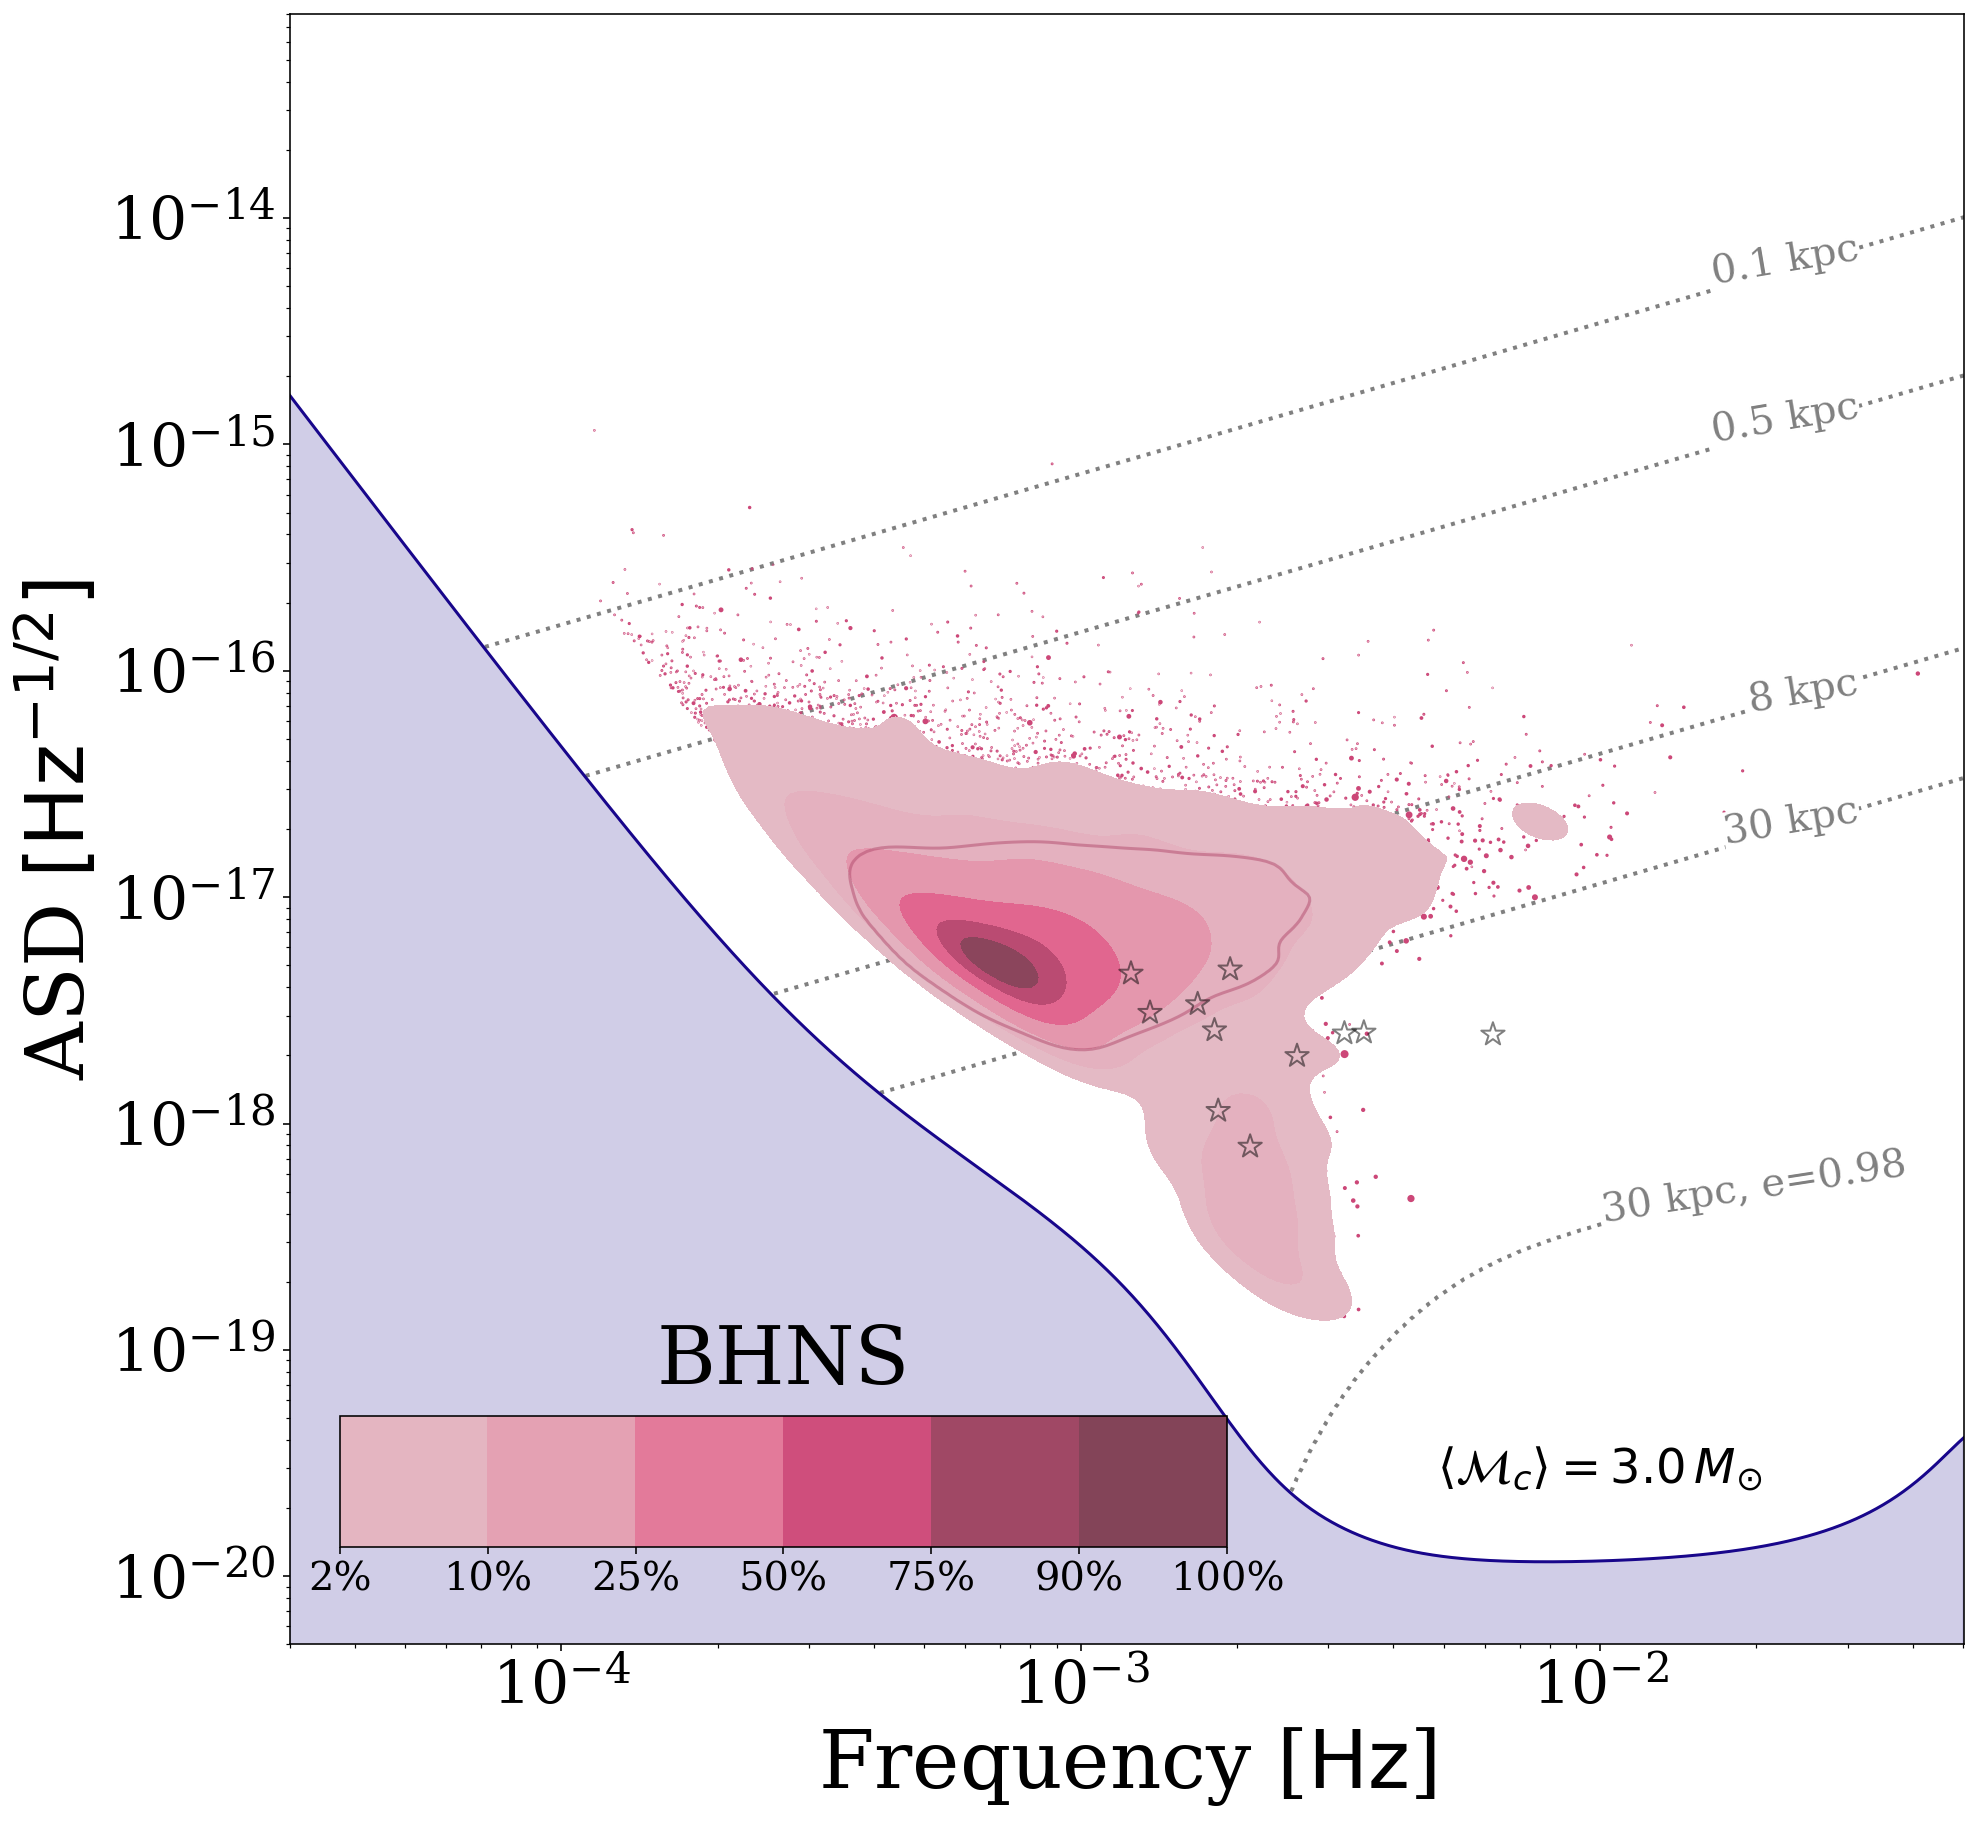

In [455]:
frequency_range = np.logspace(np.log10(3e-5), -1.3, 1000) * u.Hz

fig, ax = plt.subplots(figsize=(15, 15))

levels = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]

# ax.annotate("Galactic centre",
#                 xy=(7e-4, 5e-18), xycoords='data',
#                 xytext=(9e-5, 2e-18), textcoords='data',
#                 arrowprops=dict(arrowstyle="simple", color="black",
#                                 connectionstyle="angle3,angleA=90,angleB=0"),
#                 fontsize=fs, ha="center", va="center")

# ax.annotate("Eccentric sources",
#                 xy=(2.3e-3, 4e-19), xycoords='data',
#                 xytext=(2e-4, 7e-19), textcoords='data',
#                 arrowprops=dict(arrowstyle="simple", color="black",
#                                 connectionstyle="angle3,angleA=120,angleB=10", relpos=(0.5, 1.0)),
#                 fontsize=fs, ha="center", va="center")

f_GWs = [vb["f_GW"].to(u.Hz).value for vb in verification_binaries if vb["snr"] > 7]
ASDs = [(legwork.psd.lisa_psd(vb["f_GW"])**(0.5) * vb["snr"]).to(u.Hz**(-1/2)).value for vb in verification_binaries if vb["snr"] > 7]
ax.scatter(f_GWs, ASDs, s=150, facecolor="none", edgecolor="black", marker="*", alpha=0.5,
               label="Verification binaries", zorder=10)

fig, ax = plot_sc_with_dist_lines(frequency_range, fig=fig, ax=ax,
                                       mc_mean=fid_sources[1].m_c.mean().round(2),
                                       mc_min=fid_sources[1].m_c.min(), line_scale=2, line_rot=8, loc=-50)

# the lazy man's guide to colorbars: just plot hidden points
cmap = cmap_from_colour(dco_colours[dco_types[1]])
scatter = ax.scatter(np.ones_like(levels) * 1e-5, np.ones_like(levels) * 1e-21, c=levels, cmap=cmap)
inset_ax = ax.inset_axes([0.03, 0.06, 0.53, 0.08])
cbar = fig.colorbar(scatter, ax=ax, cax=inset_ax, boundaries=levels, orientation="horizontal")
cbar.set_ticklabels(["2%", "10%", "25%", "50%", "75%", "90%", "100%"])
cbar.ax.tick_params(labelsize=fs)

f_dom = fid_sources[1].f_orb * fid_sources[1].max_snr_harmonic
legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=f_dom,
                                                  snr=fid_sources[1].snr, fig=fig, ax=ax, show=False,
                                                  color=dco_colours[dco_types[1]], s=fid_sources[1].weight * 25)

legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=f_dom,
                                                  snr=fid_sources[1].snr, fig=fig, ax=ax, show=False,
                                                  color=dco_colours[dco_types[1]], weights=fid_sources[1].weight,
                                                  disttype="kde", fill=True, levels=levels)

mask = fid_sources[1].ecc < 0.01
color = list(cmap(0.75))
color[-1] = 0.5
legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=f_dom[mask], snr=fid_sources[1].snr[mask],
                                                  fig=fig, ax=ax, show=False, color=tuple(color),
                                                  weights=fid_sources[1].weight[mask], disttype="kde",
                                                  fill=False, levels=[0.1])

ax.annotate(dco_types[1], xy=(0.295, 0.15), xycoords="axes fraction",
                 fontsize=2*fs, color="black", ha="center", va="bottom")

print(dco_types[1], "done")

ylims = (5e-21, 8e-14)

ax.set_ylim(ylims)
    
ax.tick_params(labelsize=1.5 * fs)
ax.xaxis.label.set_fontsize(2 * fs)
ax.yaxis.label.set_fontsize(2 * fs)

plt.show()

<Quantity 8.16993464e-05 Hz>

In [461]:
sources = legwork.source.Source(m_1=0.4*u.Msun, m_2=0.06*u.Msun, f_orb=(1 / (3.4 * u.hour)).to(u.Hz), ecc=0.0, dist=5 *u.kpc, interpolate_g=False)

In [463]:
sources.get_snr(verbose=True)

Calculating SNR for 1 sources
	1 sources are stationary
		1 sources are stationary and circular


array([0.00192989])

BHBH
BHNS
NSNS


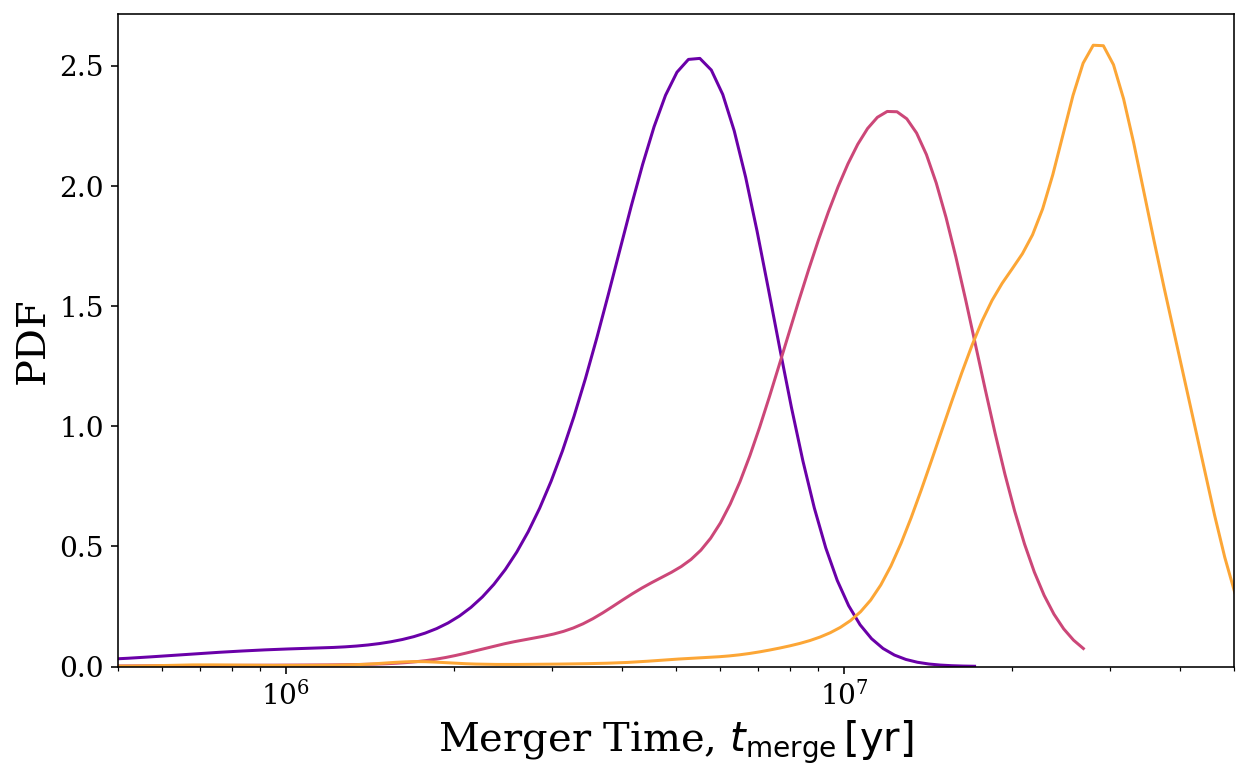

In [451]:
fig, ax = plt.subplots(figsize=(10, 6))

for dco_type in dco_types:

    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, "fiducial"), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] > 7
        data = full_data[snr_mask]

        # make everything unique and adjust weights
        _, uni_index, uni_count = np.unique(data["seed"],
                                            return_index=True, return_counts=True)
        data = data[uni_index]
        data["weight"] *= uni_count

    t_merge = legwork.evol.get_t_merge_ecc(ecc_i=data["e_DCO"], a_i=data["a_DCO"] * u.AU,
                                           m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun)

    t_merge_left = ((data["tau"] - t_merge.to(u.Gyr).value) * u.Gyr).to(u.Myr).value
    
    
    reasonable = t_merge_left > 0
    
    print(dco_type)
    
    sns.kdeplot(t_merge_left[reasonable] * 1e6, weights=data["weight"][reasonable],
                          bw_adjust=1.4, ax=ax, label=dco_type, color=dco_colours[dco_type], log_scale=(True, False), cumulative=False)

#     ax = bootstrapped_kde(t_merge_left[reasonable], data["weight"][reasonable], data["seed"][reasonable],
#                           bw_adjust=1.4, ax=ax, label=dco_type, color=dco_colours[dco_type]) #color="#74BB36"

    ax.set_xlabel(r"Merger Time, $t_{\rm merge} \, [\rm yr]$")
    ax.set_xlim(5e5, 5e7)
#     ax.set_ylim(bottom=0.0)

    ax.set_ylabel("PDF")

plt.show()

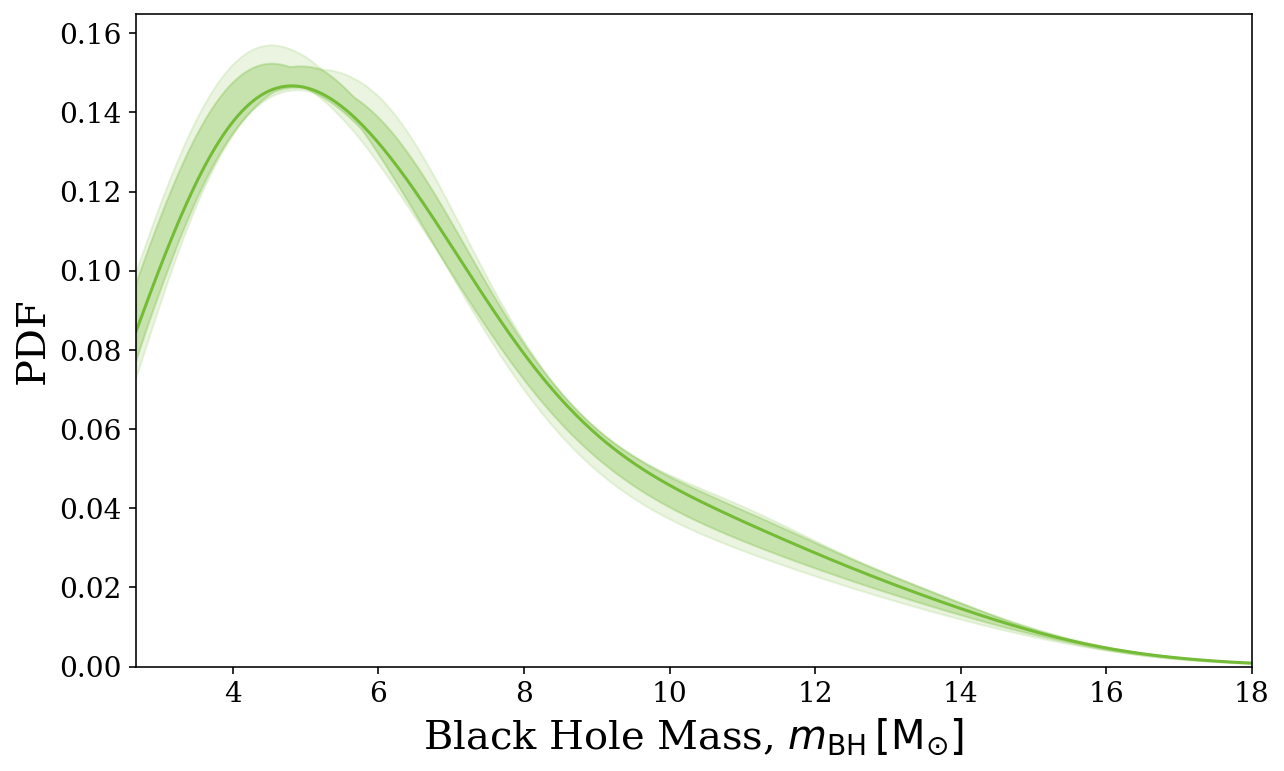

In [344]:
fig, ax = plt.subplots(figsize=(10, 6))
    
mBH = np.maximum(data["m_1"], data["m_2"])
mNS = np.minimum(data["m_1"], data["m_2"])
mass_weights = data["weight"]
mass_seeds = data["seed"]

ax= bootstrapped_kde(mBH, mass_weights, mass_seeds, bw_adjust=1.4, ax=ax, color="", label=dco_type, bootstraps=5)

ax.set_xlabel(r"Black Hole Mass, $m_{\rm BH} \, [\rm M_{\odot}]$")
ax.set_xlim(2.67, 18)
ax.set_ylim(bottom=0.0)

ax.set_ylabel("PDF")

plt.show()